<a href="https://colab.research.google.com/github/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow/blob/main/cristie_mod6_proj_final_parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# **Ciência de Dados: Fundamentos de Machine Learning**
---
---

## **Pós-graduação em Ciência de Dados (2025/2026)**

**Escola Superior de Tecnologia da Universidade Estadual do Amazonas - EST/UEA**
    
**Disciplina:** Fundamentos de Machine Learning

**Prof. Me.:** Mario Bessa

_**Repositório do Projeto Acadêmico no Github:** [e-SUS_Sinan_Mpox_ML-Workflow](https://github.com/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow)_

_**Aluna:**_

- _A. Cristiane R. Lima (Cristie)_

_**Data:** 10 de setembro de 2025_


## **Projeto Final**
Este projeto está dividido em 2 notebooks para contemplar o fluxo completo de pré-modelagem e modelagem para o dataset [e-SUS Sinan/Mpox](https://opendatasus.saude.gov.br/ne/dataset/mpox), seguindo uma estrutura padronizada, do seguinte modo:

- cristie_mod6_proj_final_parte_1.ipynb: Aquisição, Análise Descritiva e Exploratória de Dados (EDA), Pré-processamento (Correção )

Foi desenvolvido a partir do notebook-base apresentado e explicado ao longo as aulas teórico-práticas em laboratório do Professor.

---

💡 **Nota técnica:** O link para o Dicionário de Dados está disponível na seção de *Análise Descritiva*. Recomenda-se mantê-lo aberto para facilitar a interpretação das variáveis.

⚠️ **Observação:** Linhas com o comentário `#debug#` indicam trechos opcionais para testes e inspeções pontuais — como a geração de arquivos `.csv` temporários para verificar o estado do DataFrame após imputações.

📚 **Referência:**  
KELLEHER, John D.; MAC NAMEE, Brian; D’ARCY, Aoife. *Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies*. 2. ed. Cambridge, MA: MIT Press, 2020.


---
### **Contextualização do Projeto**

A Mpox (Monkeypox) é uma doença infecciosa emergente que ganhou atenção internacional devido ao seu potencial de disseminação e impacto na saúde pública. No Brasil, o sistema e-SUS Sinan tem sido fundamental para o registro e monitoramento dos casos, permitindo a construção de bases de dados estruturadas para análise epidemiológica.

Este projeto tem como objetivo aplicar técnicas de aprendizado de máquina para explorar, tratar e modelar os dados disponíveis, com foco na geração de insights preditivos que possam apoiar estratégias de vigilância e resposta. A abordagem adotada contempla desde o pré-processamento e imputação de dados até a construção de modelos supervisionados, seguindo diretrizes metodológicas discutidas em ambiente acadêmico.

---

**Instruções:**

- Realizar os processamentos abaixo:

  - No notebook `cristie_mod6_proj_final_parte_1.ipynb`:
    -  Atividade 1: Limpar dados incorretos
    -  Atividade 2: Imputação de valores faltantes
  - No notebook `cristie_mod6_proj_final_parte_2.ipynb`:
    -  Atividade 3: Codificação de variáveis categóricas (OrdinalEncoder e OneHotEncoder)
    -  Atividade 4: Escalonamento de variáveis numéricas (StandardScaler e MinMaxScaler)
    -  Atividade 5: Balanceamento dos dados (Tomek e Smote)
    -  Atividade 6: Treinamento dos modelos de Machine Learning
    -  Atividade 7: Usar o modelo treinado

## **Importa bibliotecas**

In [1]:
# !pip -q install
"""
!pip install pandas --upgrade
!pip install numpy --upgrade

!pip install matplotlib --upgrade
!pip install seaborn --upgrade

!pip install plotly --upgrade
!pip install yellowbrick --upgrade

!pip install sklearn --upgrade
"""

'\n!pip install pandas --upgrade\n!pip install numpy --upgrade\n\n!pip install matplotlib --upgrade\n!pip install seaborn --upgrade\n\n!pip install plotly --upgrade\n!pip install yellowbrick --upgrade\n\n!pip install sklearn --upgrade\n'

In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns

import joblib
import matplotlib.pyplot as plt
import warnings

In [3]:
# Para aplicar OrdinalEncoder ou OneHotEncoder em variáveis categóricas
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Para aplicar StandardScaler e MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Para filtro de variância
from sklearn.feature_selection import VarianceThreshold

# Para seleção supervisionada — RFE (Recursive Feature Elimination)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Para seleção supervisionada — Feature Importance (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# Para aplicar Mutual Information entre X e cada alvo
from sklearn.feature_selection import mutual_info_classif

# Para cálculo de métricas no Benchmark com Regressão Logística (StandardScaler + MinMaxScaler) ---
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score



# Para garantir X 100% numérico e sem NaN antes de Tomek/SMOTE
from sklearn.impute import SimpleImputer

# Para aplicar TomerkLinks e SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE



In [4]:
# Para divisão das bases em treinamento e teste
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

## **Tarefas preliminares: Desserialização inicial**

In [5]:
# Tarefas preliminares
#import pandas as pd

url = "https://github.com/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow/raw/refs/heads/main/data/mpox_2022_prep.parquet"
#url = "https://raw.githubusercontent.com/Cristie-Lima/e-SUS_Sinan_Mpox_ML-Workflow/main/data/mpox_2022_prep.parquet" outra opção válida

# Carregar o parquet diretamente do GitHub
df_prep = pd.read_parquet(url, engine="pyarrow")  # ou engine="fastparquet"

print("✅ df_prep carregado com sucesso:", df_prep.shape)
df_prep.head()


✅ df_prep carregado com sucesso: (10920, 114)


,CLASSI_FIN,SG_UF,SG_UF_NOT,ID_MUNICIP,DT_NOTIFIC,CO_UF_RES,ID_MN_RESI,NU_IDADE_N,CS_SEXO,COMP_SEXUAL,...,CLADO_missing,DOENCA_TRA.1_missing,NU_IDADE_N_missing,CONTAG_CD4_missing,DT_NOTIFIC_missing,DT_SIN_PRI_missing,DT_COLETA_missing,DATA_VACINA_missing,DT_INTERNA_missing,DT_EVOLUCAO_missing
0,1,PB,PB,250750,2022-12-08,25,250750,34,1,1,...,0,0,0,0,0,0,0,1,1,0
1,1,PR,PR,410690,2022-08-09,41,410690,36,1,1,...,0,0,0,1,0,0,0,1,1,0
2,1,PR,PR,410690,2022-08-08,41,410690,32,1,1,...,0,0,0,1,0,0,0,1,1,0
3,1,ES,PR,410690,2022-08-08,32,320520,29,1,1,...,0,0,0,1,0,0,0,1,1,0
4,1,PR,PR,410690,2022-08-05,41,410690,47,2,1,...,0,0,0,1,0,0,1,1,1,0


## 📌 Nota da seção – Desserialização dos dados

- O dataset pré-processado (`df_prep`) foi desserializado a partir do arquivo `.parquet`.  
- Esta etapa marca o início da **Parte 2 (Engenharia de Atributos & Modelagem)**.  
- Próximas etapas: **codificação das variáveis categóricas** e **escalonamento das variáveis numéricas**.

---

## **🛠️ Engenharia de Atributos — Criação de novas variáveis a partir das existentes**  

Nesta etapa, o dataset é enriquecido com variáveis derivadas, combinando atributos originais para aumentar a expressividade do modelo.  

**Resumo das ações implementadas:**  
1. **Explosão de `SINTOMA` → dummies** (`sx_*`), preservando todos os sintomas (min_freq=None).  
2. **Deltas de datas**: cálculo de intervalos temporais (notificação, evolução, internação, duração do caso).  
3. **Agregados clínicos**: indicadores de ISTs, imunossupressão e vacinação.  
4. **Bins demográficos / Região**: faixas etárias e classificação por região (IBGE).  
5. **Interações**: combinações pragmáticas, como imuno × sintomas e centralização de `delay_notif` por região.  
6. **Targets**: derivação das variáveis-alvo binárias (`target_hosp`, `target_obito_any`, `target_obito_mpx`).  
7. **Auditorias**: checagem de sanidade, NAs e relevância clínica das novas variáveis.  

---


### Engenharia de Atributos — Funções

In [6]:
# ==========================================
# ⚙️ ENGENHARIA DE ATRIBUTOS — FUNÇÕES E EXECUÇÃO
# ==========================================
#import pandas as pd
#import numpy as np

# ------------------------------------------------------------
# 1) Explosão de sintomas em dummies (com min_freq opcional)
# ------------------------------------------------------------
def explode_sintoma_dummies_simple(
    df: pd.DataFrame,
    col: str = "SINTOMA",
    prefix: str = "sx_",
    min_freq: int | None = None
) -> tuple[pd.DataFrame, list]:
    """
    Transforma a coluna de sintomas (strings separadas por vírgula) em colunas dummies (0/1).

    Parâmetros
    ----------
    df : DataFrame
        Base de entrada.
    col : str
        Nome da coluna que contém a lista de sintomas (ex.: "Febre, Cefaleia").
    prefix : str
        Prefixo a ser usado nas colunas dummies geradas (ex.: "sx_").
    min_freq : int | None
        - None → mantém TODOS os sintomas (recomendado para saúde; preserva informação).
        - inteiro ≥1 → mantém apenas sintomas com frequência absoluta ≥ min_freq
                       (útil futuramente para reduzir esparsidade).

    Retorno
    -------
    df_out : DataFrame
        DataFrame original + colunas dummies para cada sintoma selecionado.
    sintomas_cols : list[str]
        Lista com os nomes das colunas de sintomas criadas.
    """
    df_out = df.copy()

    if col not in df_out.columns:
        return df_out, []

    # Lista de sintomas por linha (minúsculas, trim de espaços; ignora strings vazias)
    s_clean = df_out[col].fillna("").astype(str)
    listas = s_clean.str.split(",").apply(lambda xs: [t.strip().lower() for t in xs if t.strip() != ""])

    # Frequência dos termos
    freq = pd.Series([t for sub in listas for t in sub]).value_counts()

    # Seleção por min_freq (se None → todos)
    if min_freq is None:
        termos = freq.index
    else:
        termos = freq[freq >= int(min_freq)].index

    # Criação de dummies (0/1) linha a linha
    for termo in termos:
        c = f"{prefix}{termo.replace(' ', '_')}"
        df_out[c] = listas.apply(lambda L: int(termo in L)).astype("Int64")

    sintomas_cols = [c for c in df_out.columns if c.startswith(prefix)]
    return df_out, sintomas_cols


# ------------------------------------------------------------
# 2) Features derivadas de datas (sem imputar datas)
# ------------------------------------------------------------
def add_date_features(
    df: pd.DataFrame,
    col_notif: str = "DT_NOTIFIC",
    col_inicio: str = "DT_SIN_PRI",
    col_evol: str = "DT_EVOLUCAO",
    col_intern: str = "DT_INTERNA",
    create_missing_flags: bool = True
) -> pd.DataFrame:
    """
    Cria deltas de tempo (em dias) a partir de colunas de datas — sem imputação.
    Se a linha não tiver ambas as datas válidas, o delta fica NaN.

    Parâmetros
    ----------
    df : DataFrame
        Base de entrada (datas podem estar em string; serão convertidas durante o cálculo).
    col_notif, col_inicio, col_evol, col_intern : str
        Nomes das colunas de datas conforme o dicionário.
    create_missing_flags : bool
        Se True, mantém/gera indicadores *_missing (0/1) para cada coluna de data original.

    Retorno
    -------
    DataFrame com as colunas:
      - delay_notif        = DT_NOTIFIC - DT_SIN_PRI
      - tempo_internacao   = DT_EVOLUCAO - DT_INTERNA
      - duracao_caso       = DT_EVOLUCAO - DT_SIN_PRI
    """
    out = df.copy()

    # Flags de ausência (se existirem as colunas)
    def _flag(col):
        if create_missing_flags and col in out.columns:
            out[f"{col}_missing"] = out[col].isna().astype("Int64")

    for c in [col_notif, col_inicio, col_evol, col_intern]:
        _flag(c)

    # Converte sob demanda apenas para calcular deltas
    to_dt = lambda s: pd.to_datetime(s, errors="coerce", dayfirst=True)

    if {col_notif, col_inicio}.issubset(out.columns):
        out["delay_notif"] = (to_dt(out[col_notif]) - to_dt(out[col_inicio])).dt.days

    if {col_evol, col_intern}.issubset(out.columns):
        out["tempo_internacao"] = (to_dt(out[col_evol]) - to_dt(out[col_intern])).dt.days

    if {col_evol, col_inicio}.issubset(out.columns):
        out["duracao_caso"] = (to_dt(out[col_evol]) - to_dt(out[col_inicio])).dt.days

    return out


# ------------------------------------------------------------
# 3) Agregados clínicos (ISTs, imunossupressão, vacinação)
# ------------------------------------------------------------
def add_clinical_aggregates(
    df: pd.DataFrame,
    ist_cols: list | None = None,
    col_imuno: str = "PAC_IMUNOSSUP",
    col_vacina: str = "VACINA"
) -> pd.DataFrame:
    """
    Cria agregações clínicas:

    - ist_any   : 1 se pelo menos uma IST específica = 1; 0 caso contrário (ignora NaN ao somar/max).
    - ist_count : soma das ISTs específicas (contagem).
    - imune_risco:
        PAC_IMUNOSSUP (1,2,3) → 1; 4→0; outros (9/NaN) → NA.
    - vacina_qualquer:
        VACINA in {1,2,3} → 1; VACINA==4 → 0; caso contrário → NA.

    Parâmetros
    ----------
    df : DataFrame
    ist_cols : list | None
        Lista explícita de colunas de ISTs. Se None, usa o conjunto padrão do mpox_2022.
    col_imuno : str
        Nome da coluna de imunossupressão.
    col_vacina : str
        Nome da coluna de vacinação.

    Retorno
    -------
    DataFrame com novas colunas: ist_any, ist_count, imune_risco, vacina_qualquer.
    """
    out = df.copy()

    if ist_cols is None:
        ist_cols = [
            "GONORREIA","CLAMIDEA","SIFILIS","HERPES_GENITAL","CANCRO_MOLE",
            "TRICHOMOMAS_VAGINALS","LINFOGRANULOMA","MYCOPLASMA_GENITAL",
            "HPV","DIP","DONOVANOSE","HTLV","VERRUGA_GENITAL"
        ]
    ist_cols = [c for c in ist_cols if c in out.columns]

    if ist_cols:
        out["ist_any"] = out[ist_cols].max(axis=1, skipna=True).astype("Int64")
        out["ist_count"] = out[ist_cols].sum(axis=1, skipna=True).astype("Int64")

    if col_imuno in out.columns:
        m = out[col_imuno].map({1:1, 2:1, 3:1, 4:0})
        out["imune_risco"] = m.astype("Int64")

    if col_vacina in out.columns:
        v = pd.Series(pd.NA, index=out.index, dtype="Int64")
        v = v.mask(out[col_vacina].isin([1,2,3])==True, 1)
        v = v.mask(out[col_vacina].eq(4)==True, 0)
        out["vacina_qualquer"] = v

    return out


# ------------------------------------------------------------
# 4) Bins demográficos / Região (UF→região)
# ------------------------------------------------------------
def add_demo_bins(
    df: pd.DataFrame,
    col_idade: str = "NU_IDADE_N",
    col_uf: str = "SG_UF"
) -> pd.DataFrame:
    """
    Cria faixas etárias e região (a partir de SG_UF).
    - faixa_etaria: categorias textuais (0–9, 10–17, 18–29, 30–39, 40–49, 50–59, 60+).
      (Mantém NaN quando NU_IDADE_N ausente).
    - regiao: Norte, Nordeste, Centro-Oeste, Sudeste, Sul (NaN se SG_UF ausente ou desconhecido).

    Parâmetros
    ----------
    df : DataFrame
    col_idade : str
        Nome da coluna de idade (anos).
    col_uf : str
        Nome da coluna de UF (sigla).

    Retorno
    -------
    DataFrame com 'faixa_etaria' (category) e 'regiao' (category).
    """
    out = df.copy()

    # Faixas etárias (ajustáveis)
    if col_idade in out.columns:
        bins = [-np.inf, 9, 17, 29, 39, 49, 59, np.inf]
        labels = ["0-9","10-17","18-29","30-39","40-49","50-59","60+"]
        out["faixa_etaria"] = pd.cut(out[col_idade], bins=bins, labels=labels).astype("category")

    # Mapeamento UF → Região (IBGE)
    uf_regiao = {
        # Norte
        "AC":"Norte","AP":"Norte","AM":"Norte","PA":"Norte","RO":"Norte","RR":"Norte","TO":"Norte",
        # Nordeste
        "AL":"Nordeste","BA":"Nordeste","CE":"Nordeste","MA":"Nordeste","PB":"Nordeste",
        "PE":"Nordeste","PI":"Nordeste","RN":"Nordeste","SE":"Nordeste",
        # Centro-Oeste
        "DF":"Centro-Oeste","GO":"Centro-Oeste","MS":"Centro-Oeste","MT":"Centro-Oeste",
        # Sudeste
        "ES":"Sudeste","MG":"Sudeste","RJ":"Sudeste","SP":"Sudeste",
        # Sul
        "PR":"Sul","RS":"Sul","SC":"Sul",
    }
    if col_uf in out.columns:
        out["regiao"] = out[col_uf].map(uf_regiao).astype("category")

    return out


# ------------------------------------------------------------
# 5) Interações (exemplos pragmáticos)
# ------------------------------------------------------------
def add_interactions(
    df: pd.DataFrame,
    sintomas_prefix: str = "sx_",
    center_delay_by: str = "regiao"
) -> pd.DataFrame:
    """
    Cria interações/transformações simples:

    - sintoma_count: soma dos dummies de sintomas (se existirem colunas com prefixo sintomas_prefix).
    - imune_risco_x_sintomas: produto de imune_risco * sintoma_count (se ambas existirem).
    - delay_notif_centered_regiao: delay_notif centrado pela média da região (se 'regiao' existir).

    Parâmetros
    ----------
    df : DataFrame
    sintomas_prefix : str
        Prefixo que identifica as colunas dummies de sintomas (default 'sx_').
    center_delay_by : str
        Coluna categórica para centralizar delay_notif por grupo (default 'regiao').

    Retorno
    -------
    DataFrame com novas colunas se aplicáveis.
    """
    out = df.copy()

    # Conta dummies de sintomas
    sint_cols = [c for c in out.columns if c.startswith(sintomas_prefix)]
    if sint_cols:
        out["sintoma_count"] = out[sint_cols].sum(axis=1, skipna=True).astype("Int64")

    # Interação com imunossupressão
    if {"imune_risco","sintoma_count"}.issubset(out.columns):
        # Usa 0 para NA ao multiplicar; resultado volta a Int64 com NA onde ambos eram NA
        tmp = out["imune_risco"].fillna(0) * out["sintoma_count"].fillna(0)
        tmp = tmp.mask(out["imune_risco"].isna() & out["sintoma_count"].isna(), pd.NA)
        out["imune_risco_x_sintomas"] = tmp.astype("Int64")

    # Centralização de delay_notif por região (ou outra coluna categórica)
    if "delay_notif" in out.columns and center_delay_by in out.columns:
        out["delay_notif_centered_regiao"] = (
            out["delay_notif"] - out.groupby(center_delay_by, observed=False)["delay_notif"].transform("mean")
        )

    return out


# ------------------------------------------------------------
# 6) Targets (variáveis-alvo binárias)
# ------------------------------------------------------------
def add_targets(
    df: pd.DataFrame,
    col_hosp: str = "HOSPITAL",
    col_evol: str = "EVOLUCAO"
) -> pd.DataFrame:
    """
    Cria variáveis-alvo padronizadas para classificação:

    - target_hosp      : 1 se HOSPITAL == 1; 0 caso contrário (Int64 com NA onde não há dado).
    - target_obito_any : 1 se EVOLUCAO ∈ {1 (óbito MPX), 3 (óbito outra causa)}; 0 caso contrário.
    - target_obito_mpx : 1 se EVOLUCAO == 1; 0 caso contrário.

    Parâmetros
    ----------
    df : DataFrame
    col_hosp : str
        Nome da coluna de hospitalização (código).
    col_evol : str
        Nome da coluna de evolução (código).

    Retorno
    -------
    DataFrame com as três colunas de target.
    """
    out = df.copy()

    if col_hosp in out.columns:
        t = out[col_hosp].eq(1)
        out["target_hosp"] = t.where(out[col_hosp].notna(), pd.NA).astype("Int64")

    if col_evol in out.columns:
        any_obito = out[col_evol].isin([1,3])
        out["target_obito_any"] = any_obito.where(out[col_evol].notna(), pd.NA).astype("Int64")
        mpx = out[col_evol].eq(1)
        out["target_obito_mpx"] = mpx.where(out[col_evol].notna(), pd.NA).astype("Int64")

    return out


# ------------------------------------------------------------
# 7) Auditorias
# ------------------------------------------------------------
def audit_sintomas(df: pd.DataFrame, sintomas_cols: list[str]) -> pd.DataFrame:
    """
    Auditoria das dummies de sintomas:
    - non_nulls, sum_positives, percent_positives
    - status: marca colunas sempre-zero / sempre-NaN
    """
    if not sintomas_cols:
        return pd.DataFrame({"msg": ["Sem colunas de sintomas (prefixo não encontrado)."]})

    audit = pd.DataFrame({
        "non_nulls": df[sintomas_cols].notna().sum(),
        "sum_positives": df[sintomas_cols].sum(),
        "percent_positives": df[sintomas_cols].mean() * 100
    })
    audit["status"] = "-"
    audit.loc[audit["sum_positives"] == 0, "status"] = "⚠️ Sempre 0"
    audit.loc[audit["non_nulls"] == 0, "status"] = "⚠️ Sempre NaN"
    return audit.sort_values("percent_positives", ascending=False)


def audit_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Checagem rápida de presença e sanidade das principais novas features.
    Retorna um pequeno quadro-resumo (counts/NA/descrição de colunas-chave).
    """
    cols_check = [
        "delay_notif","tempo_internacao","duracao_caso",
        "ist_any","ist_count","imune_risco","vacina_qualquer",
        "faixa_etaria","regiao","sintoma_count","imune_risco_x_sintomas",
        "delay_notif_centered_regiao",
        "target_hosp","target_obito_any","target_obito_mpx"
    ]
    cols_check = [c for c in cols_check if c in df.columns]
    if not cols_check:
        return pd.DataFrame({"msg": ["Nenhuma coluna derivada encontrada para auditar."]})

    out = []
    for c in cols_check:
        s = df[c]
        out.append({
            "col": c,
            "dtype": str(s.dtype),
            "non_null": int(s.notna().sum()),
            "na": int(s.isna().sum()),
            "unique": int(s.nunique(dropna=True)),
            "sample_values": s.dropna().unique()[:5] if s.nunique(dropna=True) <= 10 else "many"
        })
    return pd.DataFrame(out).set_index("col")

### **Implementação da Estrutura de Engenharia de Atributos**

Neste momento como ainda está-se a explorar e atuar na Engenharia de Atributos, melhor manter todos os dummies de sintomas

In [7]:
# ------------------------------------------------------------
# 8) PIPELINE DE EXECUÇÃO (orquestra todas as etapas)
# ------------------------------------------------------------
def run_feature_engineering_pipeline(
    df: pd.DataFrame,
    sintomas_min_freq: int | None = None
) -> tuple[pd.DataFrame, dict]:
    """
    Executa a Engenharia de Atributos end-to-end:

    Etapas:
      1. Explosão de SINTOMA → dummies (min_freq opcional; default preserva todos).
      2. Deltas de datas (sem imputar; respeita NaT).
      3. Agregados clínicos (ISTs, imuno, vacina).
      4. Bins demográficos (idade, região).
      5. Interações (ex.: imuno × sintomas, centralização de delay por região).
      6. Targets (hosp, óbito).
      7. Auditorias.

    Parâmetros
    ----------
    df : DataFrame
        DataFrame pós-imputação/limpeza.
    sintomas_min_freq : int | None
        Cutoff para filtrar sintomas raros (None = mantém todos).

    Retorno
    -------
    df_feat : DataFrame
        DataFrame final enriquecido com todas as features derivadas.
    info : dict
        Dicionário com artefatos úteis:
          - 'sintomas_cols': lista de colunas dummies geradas
          - 'audit_sintomas': DataFrame de auditoria de sintomas
          - 'audit_features': DataFrame de auditoria final de features
    """
    # 1) Sintomas → dummies
    df1, sx_cols = explode_sintoma_dummies_simple(df, col="SINTOMA", prefix="sx_", min_freq=sintomas_min_freq)

    # 2) Datas → deltas
    df2 = add_date_features(df1)

    # 3) Agregados clínicos
    df3 = add_clinical_aggregates(df2)

    # 4) Bins demográficos / região
    df4 = add_demo_bins(df3)

    # 5) Interações
    df5 = add_interactions(df4)

    # 6) Targets
    df_feat = add_targets(df5)

    # 7) Auditorias
    audit_sx = audit_sintomas(df_feat, sx_cols)
    audit_ft = audit_feature_engineering(df_feat)

    info = {
        "sintomas_cols": sx_cols,
        "audit_sintomas": audit_sx,
        "audit_features": audit_ft
    }
    return df_feat, info


# ==========================================
# 🚀 EXECUÇÃO REAL NO DATAFRAME
# (assume que já existe mpox_2022_prep como df pós-imputação)
# ==========================================
df0 = df_prep.copy()

# ► Mantém todos os sintomas (literatura/consenso: preservar informação clínica agora)
df_feateng, fe_info = run_feature_engineering_pipeline(df0, sintomas_min_freq=None)

print("\n✔️ Engenharia de atributos concluída:")
print("\nTotal de colunas:", df_feateng.shape[1])
print("Total de linhas :", df_feateng.shape[0])



✔️ Engenharia de atributos concluída:

Total de colunas: 222
Total de linhas : 10920


## 🛠️ Auditoria Pós-Engenharia de Dados

In [8]:
# Amostra de auditorias
print("\n✔️ Resultado da Auditoria Pós-Engenharia de Dados:")
print("\n[Audit] Quadro-resumo de Dummy Features de Sintomas (top 10 por % positivos):")
print(fe_info["audit_sintomas"].head(10))

print("\n\n[Audit] Quadro-resumo de Features Derivadas:")
print(fe_info["audit_features"],'\n')


✔️ Resultado da Auditoria Pós-Engenharia de Dados:

[Audit] Quadro-resumo de Dummy Features de Sintomas (top 10 por % positivos):
                    non_nulls  sum_positives  percent_positives status
sx_erupcao_cutanea      10920           7319           67.02381      -
sx_febre                10920           6288          57.582418      -
sx_lesao_genital        10920           4785          43.818681      -
sx_cefaleia             10920           4287          39.258242      -
sx_adenomegalia         10920           3809          34.880952      -
sx_dor_muscular         10920           3551          32.518315      -
sx_astenia              10920           3348          30.659341      -
sx_fraqueza             10920           3219          29.478022      -
sx_lesao_anal           10920           2335          21.382784      -
sx_dor_nas_costas       10920           1946          17.820513      -


[Audit] Quadro-resumo de Features Derivadas:
                                dtype  no

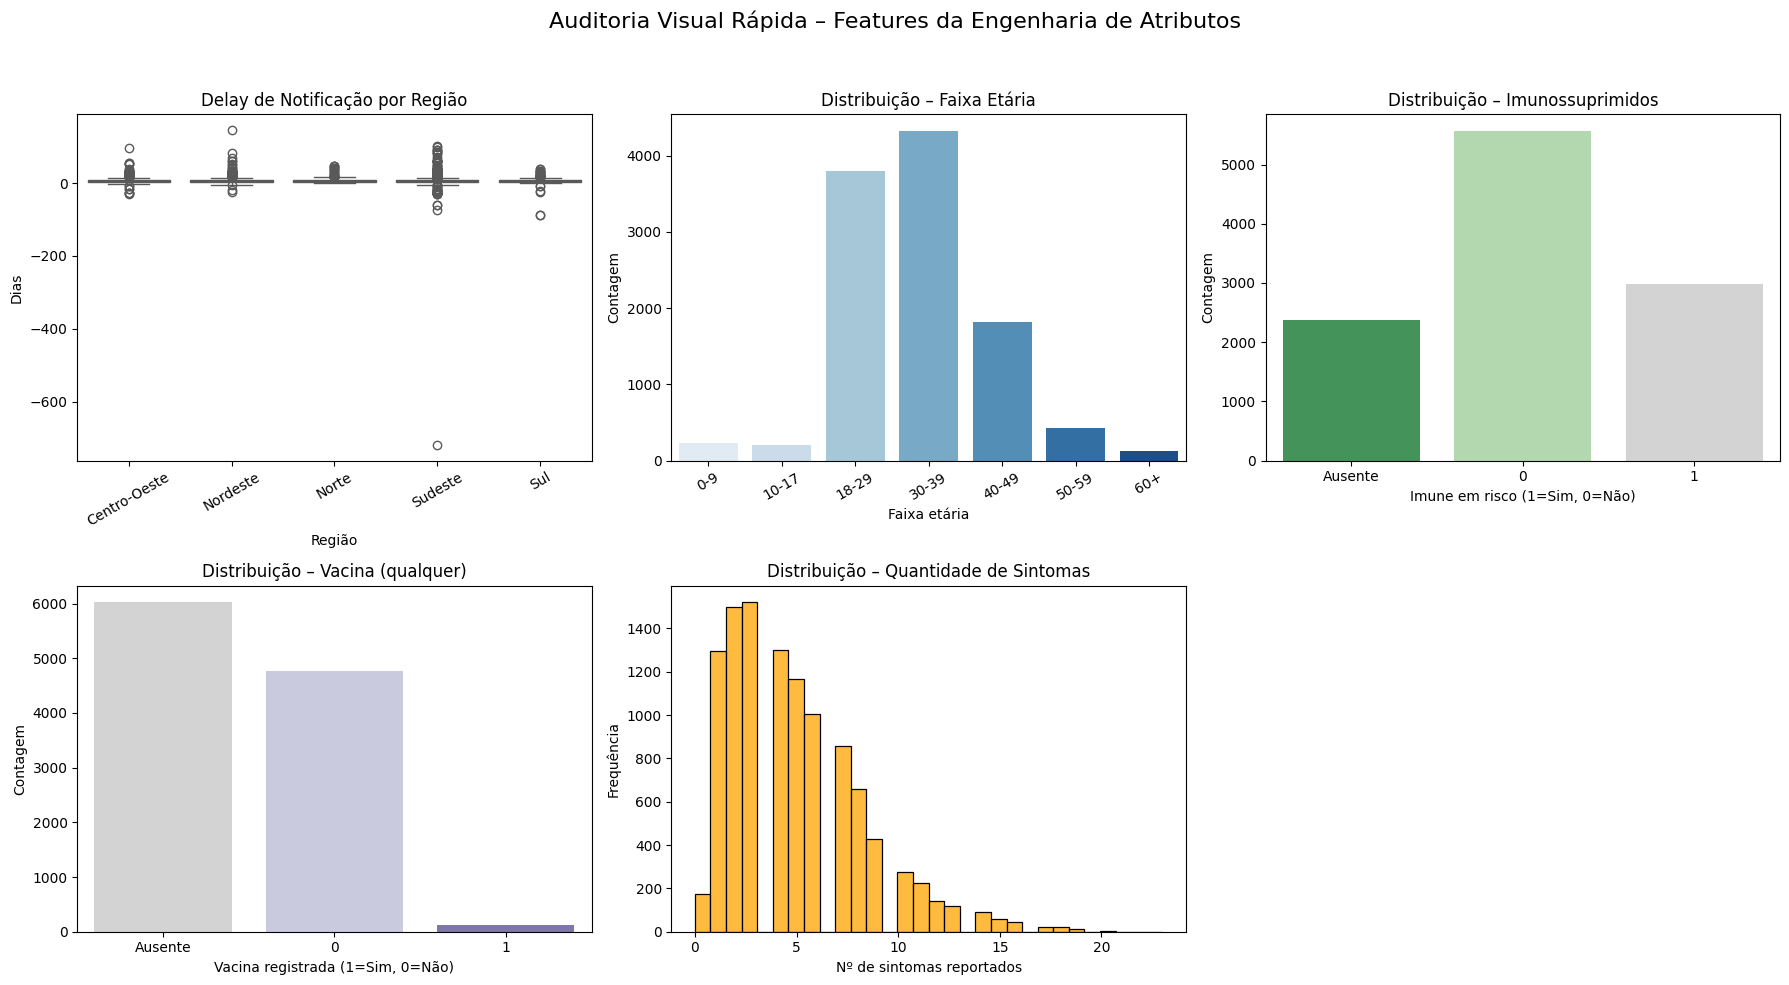

In [9]:
# ==========================================
# 📊 AUDITORIA VISUAL RÁPIDA – FEATURES ENGENHARIA DE ATRIBUTOS (com hue explícito)
# ==========================================
#import matplotlib.pyplot as plt
#import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# -----------------------------
# 1) Delay de notificação por região
# -----------------------------
col_delay = "delay_notif"
df_regiao = df_feateng["regiao"]
if df_regiao.isna().sum() > 0:
    df_regiao = df_regiao.cat.add_categories(["Ausente"]).fillna("Ausente")

sns.boxplot(
    data=df_feateng.assign(regiao=df_regiao),
    x="regiao",
    y=col_delay,
    hue="regiao",          # ✅ agora palette tem hue correspondente
    palette="Set2",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Delay de Notificação por Região")
axes[0].set_xlabel("Região")
axes[0].set_ylabel("Dias")
axes[0].tick_params(axis="x", rotation=30)

# -----------------------------
# 2) Distribuição faixa_etaria
# -----------------------------
col_faixa = "faixa_etaria"
df_faixa = df_feateng[col_faixa]
ordered_faixa = ["0-9","10-17","18-29","30-39","40-49","50-59","60+"]
if df_faixa.isna().sum() > 0:
    df_faixa = df_faixa.cat.add_categories(["Ausente"]).fillna("Ausente")
    ordered_faixa = ["Ausente"] + ordered_faixa

sns.countplot(
    data=df_feateng.assign(faixa_etaria=df_faixa),
    x="faixa_etaria",
    hue="faixa_etaria",   # ✅ hue explícito
    order=ordered_faixa,
    palette=(["lightgrey"] + sns.color_palette("Blues", len(ordered_faixa)-1)) if "Ausente" in ordered_faixa else "Blues",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Distribuição – Faixa Etária")
axes[1].set_xlabel("Faixa etária")
axes[1].set_ylabel("Contagem")
axes[1].tick_params(axis="x", rotation=30)

# -----------------------------
# 3) Distribuição imune_risco
# -----------------------------
df_imuno = df_feateng["imune_risco"].astype("Int64").astype("string")
order_imuno = ["0","1"]
if df_imuno.isna().sum() > 0:
    df_imuno = df_imuno.fillna("Ausente")
    order_imuno = ["Ausente"] + order_imuno

sns.countplot(
    data=df_feateng.assign(imune_risco=df_imuno),
    x="imune_risco",
    hue="imune_risco",   # ✅ hue explícito
    order=order_imuno,
    palette=(["lightgrey"] + sns.color_palette("Greens", len(order_imuno)-1)) if "Ausente" in order_imuno else "Greens",
    legend=False,
    ax=axes[2]
)
axes[2].set_title("Distribuição – Imunossuprimidos")
axes[2].set_xlabel("Imune em risco (1=Sim, 0=Não)")
axes[2].set_ylabel("Contagem")

# -----------------------------
# 4) Distribuição vacina_qualquer
# -----------------------------
df_vacina = df_feateng["vacina_qualquer"].astype("Int64").astype("string")
order_vacina = ["0","1"]
if df_vacina.isna().sum() > 0:
    df_vacina = df_vacina.fillna("Ausente")
    order_vacina = ["Ausente"] + order_vacina

sns.countplot(
    data=df_feateng.assign(vacina_qualquer=df_vacina),
    x="vacina_qualquer",
    hue="vacina_qualquer",   # ✅ hue explícito
    order=order_vacina,
    palette=(["lightgrey"] + sns.color_palette("Purples", len(order_vacina)-1)) if "Ausente" in order_vacina else "Purples",
    legend=False,
    ax=axes[3]
)
axes[3].set_title("Distribuição – Vacina (qualquer)")
axes[3].set_xlabel("Vacina registrada (1=Sim, 0=Não)")
axes[3].set_ylabel("Contagem")

# -----------------------------
# 5) Distribuição sintoma_count
# -----------------------------
sns.histplot(
    data=df_feateng,
    x="sintoma_count",
    bins=30,
    color="orange",
    kde=False,
    ax=axes[4]
)
axes[4].set_title("Distribuição – Quantidade de Sintomas")
axes[4].set_xlabel("Nº de sintomas reportados")
axes[4].set_ylabel("Frequência")

# -----------------------------
# Layout final
# -----------------------------
fig.delaxes(axes[5])  # remove subplot vazio
plt.suptitle("Auditoria Visual Rápida – Features da Engenharia de Atributos", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 🛠️ Síntese — Engenharia de Atributos

Nesta etapa foram criadas e avaliadas novas variáveis a partir da base original, tanto para preditores quanto para possíveis alvos.  
A auditoria confirmou a consistência dos atributos derivados, com destaque para:

- **Dummies de sintomas (`sx_*`)** → relatório das 10 mais frequentes, confirmando relevância clínica.  
- **Quadro-resumo de features derivadas** → checagem de NAs, distribuição e exemplos de valores.  
- **Targets binários candidatos** (`target_hosp`, `target_obito_any`, `target_obito_mpx`) → criados a partir de `HOSPITAL` e `EVOLUCAO`, corretamente gerados e preservados para avaliação futura.  

**Interpretação:**  
- Nenhuma feature essencial foi perdida.  
- Sintomas raros foram preservados (min_freq=None), em conformidade com boas práticas na área da saúde.  
- A base encontra-se consistente e pronta para avançar às etapas de **transformação de dados** e **seleção de atributos**.


## 💾 Salvamento e verificação da base pós-Engenharia de Atributos

In [10]:
# 💾 Salvamento final da base pós-engenharia de atributos
output_path = "mpox_2022_feateng.csv"
df_feateng.to_csv(output_path, index=False, encoding="utf-8")
print(f"✔️ Arquivo salvo em: {output_path}")

# 🔍 Verificação pós-salvamento (recarrega e confere shape + distribuição dos targets)
df_check = pd.read_csv(output_path)
print("\nCarregado de volta com sucesso:", df_check.shape)

# Lista de possíveis targets
targets = ["target_hosp", "target_obito_any", "target_obito_mpx"]

for t in targets:
    if t in df_check.columns:
        counts = (df_check[t].value_counts(normalize=True) * 100).round(2)
        distrib_dict = counts.to_dict()
        print(f"Distribuição (%) de {t}: {distrib_dict}")


✔️ Arquivo salvo em: mpox_2022_feateng.csv

Carregado de volta com sucesso: (10920, 222)
Distribuição (%) de target_hosp: {0: 97.32, 1: 2.68}
Distribuição (%) de target_obito_any: {0: 99.74, 1: 0.26}
Distribuição (%) de target_obito_mpx: {0: 99.87, 1: 0.13}


## 📊 Distribuição das opções de variáveis-alvos binárias criadas na Engenharia de Atributos

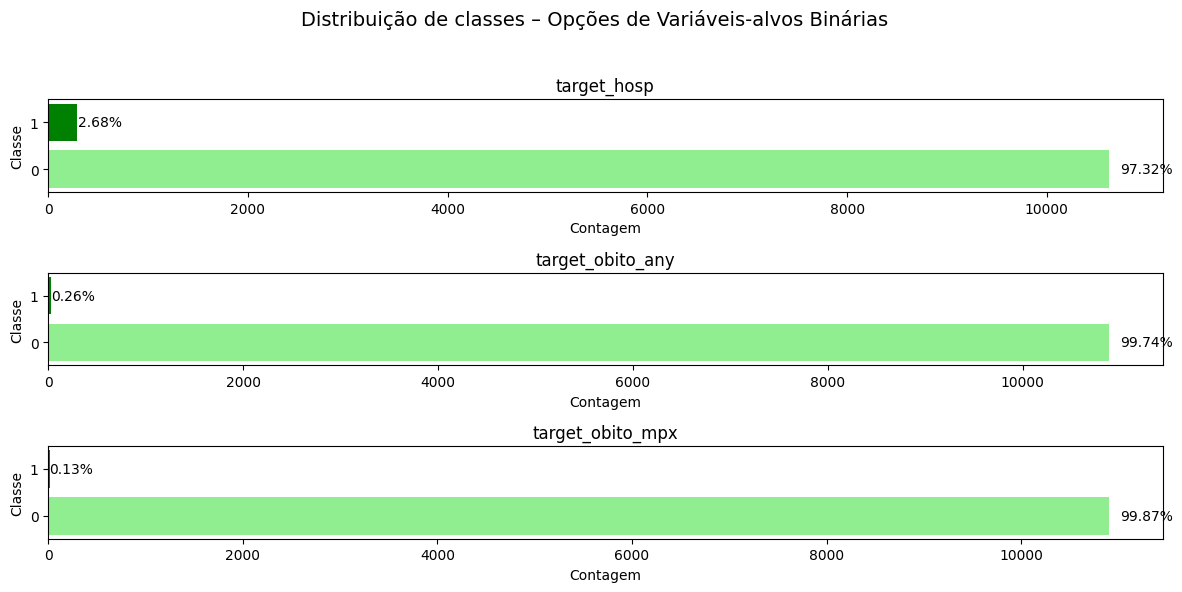

In [11]:
## 📊 Distribuição das opções de variáveis-alvos binárias criadas na Engenharia de Atributos
# 📊 (df_feateng) – barras horizontais
import matplotlib.pyplot as plt

target_cols = ["target_hosp", "target_obito_any", "target_obito_mpx"]

fig, axes = plt.subplots(len(target_cols), 1, figsize=(12, 6))  # uma coluna, várias linhas

for i, target_col in enumerate(target_cols):
    y = df_feateng[target_col].astype(int)

    counts = y.value_counts().sort_index()
    ratios = (counts / counts.sum() * 100).round(2)

    bars = axes[i].barh([str(k) for k in counts.index], counts.values,
                        color=["lightgreen", "green"], alpha=1)

    # Adicionar percentuais ao lado de cada barra
    for bar, pct in zip(bars, ratios):
        width = bar.get_width()
        axes[i].text(width + (0.01*width), bar.get_y() + bar.get_height()/2,
                     f"{pct:.2f}%", ha="left", va="center", fontsize=10)

    axes[i].set_title(f"{target_col}")
    axes[i].set_xlabel("Contagem")
    axes[i].set_ylabel("Classe")

plt.suptitle("Distribuição de classes – Opções de Variáveis-alvos Binárias", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 📌 Síntese – Distribuição das variáveis-alvo binárias

- Foram verificadas as distribuições das três variáveis-alvo derivadas na Engenharia de Atributos:  
  - `target_hosp` → indica se o paciente foi hospitalizado.  
  - `target_obito_any` → indica se houve óbito (por Mpox ou outra causa).  
  - `target_obito_mpx` → indica se o óbito foi diretamente relacionado à Mpox.  

- Cada gráfico mostra a contagem absoluta e o percentual (%) de cada classe.  
- Observação:
  - Todas são **binárias (0 = ausência, 1 = ocorrência)**.  
  - As distribuições confirmam a presença de **desbalanceamento de classes**.  
  - Nesta fase do projeto, **ainda não se definiu um único target principal**.  
  - Serão aplicadas técnicas de modelagem em todas as três opções para avaliar:  
    - Relevância clínica/epidemiológica.  
    - Estabilidade do modelo.  
    - Métricas robustas (F1-score, AUC-PR).  
  - A decisão final sobre a variável-alvo será documentada após essa análise comparativa.


## **🔄 Transformação de Dados Preparatória (Feature Transformation / Data Transformation)**


### Vetores de Colunas por Tipo de Variáveis (para as próximas etapas)

In [12]:
# ==========================================
# VETORES DE COLUNAS — ORGANIZAÇÃO POR TIPO
# (base: df_feateng após Engenharia de Atributos)
# ==========================================

# ================================
# CATEGÓRICAS NOMINAIS (texto / códigos IBGE)
# ================================
nominal_categorical_cols = [
    'SG_UF',        # sigla da UF
    'SG_UF_NOT',    # sigla da UF da notificação
    'ID_MUNICIP',   # código IBGE do município
    'CO_UF_RES',    # código IBGE da UF de residência
    'ID_MN_RESI'    # código IBGE do município de residência
]

# ================================
# NUMÉRICAS CATEGÓRICAS BINÁRIAS (0/1 já tratadas)
# ================================
numerical_as_binary_categ_cols = [
    'GONORREIA','CLAMIDEA','SIFILIS','HERPES_GENITAL','CANCRO_MOLE',
    'TRICHOMOMAS_VAGINALS','LINFOGRANULOMA','MYCOPLASMA_GENITAL',
    'HPV','DIP','DONOVANOSE','HTLV','VERRUGA_GENITAL'
]

# ================================
# NUMÉRICAS CATEGÓRICAS NOMINAIS (códigos sem ordem natural)
# ================================
numerical_as_nominal_categ_cols = [
    'CLASSI_FIN',             # classificação final
    'CS_SEXO',                # sexo do paciente
    'COMP_SEXUAL',            # comportamento sexual
    'ORIENTA_SEXUAL',         # orientação sexual
    'IDENT_GENERO',           # identidade de gênero
    'CS_RACA',                # raça/cor
    'IST_ATIVA',              # presença de IST ativa
    'TP_AMOST',               # tipo de amostra
    'ESTRANGEIRO',            # paciente estrangeiro
    'HIV',                    # status HIV
    'UTI',                    # internação em UTI
    'RESULTADO_EXA_LAB',      # resultado do exame laboratorial
    'PROFIS_SAUDE',           # paciente é profissional de saúde
    'TRATAMENTO_MONKEYPOX',   # realizou tratamento específico
    'HOSPITAL',               # status de hospitalização
    'EVOLUCAO',               # evolução do caso
    'VINCULO_EPI',            # vínculo epidemiológico
    'LOCAL_CONT',             # local provável de contágio
    'TRANSM',                 # forma de transmissão
    'CONTAT_ANIMAL',          # contato com animal
    'CS_GESTANT',             # condição gestacional
    'MET_LAB',                # método laboratorial
    'CARACT_GENOMICA',        # característica genômica
    'CLADO',                  # clado do vírus
    'DOENCA_TRA.1'            # código categórico de doença (coluna ajustada)
]

# ⚠️ Atenção:
# - PAC_IMUNOSSUP e VACINA já foram tratados na Engenharia (viraram imune_risco e vacina_qualquer).
# - SINTOMA já foi explodido em dummies sx_* na Engenharia.
# - Portanto, essas colunas não entram mais na codificação.

# ================================
# NUMÉRICAS DISCRETAS (para escalonamento posterior)
# ================================
numerical_discrete_cols = [
    'NU_IDADE_N',   # idade em anos
    'CONTAG_CD4'    # contagem de células CD4
]

# ================================
# TEMPORAIS (datas originais, mantidas para rastreio)
# ================================
date_temporal_cols = [
    'DT_NOTIFIC','DT_SIN_PRI','DT_COLETA','DATA_VACINA',
    'DT_INTERNA','DT_EVOLUCAO'
]

# ================================
# TEXTO LIVRE
# ================================
text_cols = [
    'OUTRO_DES'     # campo de descrição livre
]

# ================================
# IDENTIFICADOR TÉCNICO
# ================================
identif_cols = [
    '__arquivo_origem__'   # rastreabilidade da origem do arquivo
]

# ================================
# LISTA FINAL DE COLUNAS PARA ONE-HOT
# ================================
onehot_cols = [c for c in df_feateng.columns
               if c in nominal_categorical_cols
               or c in numerical_as_nominal_categ_cols]

print("✅ Colunas preparadas para OneHotEncoder:", onehot_cols)


✅ Colunas preparadas para OneHotEncoder: ['CLASSI_FIN', 'SG_UF', 'SG_UF_NOT', 'ID_MUNICIP', 'CO_UF_RES', 'ID_MN_RESI', 'CS_SEXO', 'COMP_SEXUAL', 'ORIENTA_SEXUAL', 'IDENT_GENERO', 'CS_RACA', 'IST_ATIVA', 'TP_AMOST', 'CS_GESTANT', 'ESTRANGEIRO', 'HIV', 'UTI', 'RESULTADO_EXA_LAB', 'PROFIS_SAUDE', 'TRATAMENTO_MONKEYPOX', 'HOSPITAL', 'EVOLUCAO', 'VINCULO_EPI', 'DOENCA_TRA.1', 'LOCAL_CONT', 'TRANSM', 'CONTAT_ANIMAL', 'MET_LAB', 'CARACT_GENOMICA', 'CLADO']


### 📌 Nota da seção – Definição dos vetores de colunas  

As variáveis do dataset foram classificadas em grupos para orientar o pré-processamento:  
- **Nominais** (ex.: `SG_UF`, `ID_MUNICIP`) → sem ordem natural.  
- **Múltiplas em texto** (ex.: `SINTOMA`) → listas de sintomas separadas por vírgula.  
- **Texto livre** (ex.: `OUTRO_DES`).  
- **Binárias (0/1)** (ex.: ISTs).  
- **Nominais numéricas** (ex.: `EVOLUCAO`, `VACINA`).  
- **Discretas** (ex.: `NU_IDADE_N`, `CONTAG_CD4`).  
- **Temporais** (ex.: `DT_NOTIFIC`, `DT_EVOLUCAO`).  

Essa organização garante consistência nas etapas de **codificação** e **escalonamento**.  

---

---
### **🔤 Atividade 3 — Codificação de Variáveis Categóricas**  

 Nesta etapa, as variáveis categóricas foram transformadas em representações numéricas adequadas para modelos de ML.

#### 🔎 Trade-offs da codificação categórica  

| Método         | Vantagens                                   | Desvantagens                                   | Indicado para |
|----------------|---------------------------------------------|------------------------------------------------|---------------|
| **OrdinalEncoder** | Simples; mantém hierarquia natural           | Induz ordens artificiais em variáveis nominais | Variáveis ordinais genuínas |
| **OneHotEncoder**  | Evita ordens falsas; compatível com ML       | Explosão de dimensionalidade                   | Variáveis nominais |
| **LabelEncoder**   | Simples; usado no *y* categórico             | Não adequado para variáveis explicativas       | Variável-alvo categórica |


---



Codificação OneHotEncoder

In [13]:
# =================================================
# 1) CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS (ONE-HOT)
# =================================================
#from sklearn.preprocessing import OneHotEncoder
#import pandas as pd

# Usa vetores já definidos no bloco anterior (garantem todas categóricas relevantes)
# ⚠️ Atenção: baseado em df_feateng
onehot_cols = [c for c in df_feateng.columns
               if c in nominal_categorical_cols
               or c in numerical_as_nominal_categ_cols]

# Inicializa encoder
encoder = OneHotEncoder(
    drop='first',            # remove a 1ª categoria de cada coluna → evita multicolinearidade
    sparse_output=False,     # saída densa → fácil converter em DataFrame
    dtype=int,               # saída como inteiros 0/1
    handle_unknown='ignore'  # ignora categorias não vistas em treino
)

# Aplica transformação
encoded = encoder.fit_transform(df_feateng[onehot_cols])

# Converte para DataFrame com os novos nomes de colunas
encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(onehot_cols),
    index=df_feateng.index
)

print(f"[OneHot] Colunas categóricas codificadas: {len(onehot_cols)}")

# Junta com o dataset original removendo colunas categóricas brutas
df_eng_ohe = pd.concat([df_feateng.drop(columns=onehot_cols), encoded_df], axis=1)


[OneHot] Colunas categóricas codificadas: 30


### Auditoria Pós-codificação de Variáveis Categóricas

In [14]:
# ==========================================
# 2) AUDITORIA PÓS-CODIFICAÇÃO
# ==========================================
print("=== Auditoria Pós-Codificação de Variáveis Categóricas ===")

# Total de colunas antes e depois
print(f"- Total antes da codificação: {df_feateng.shape[1]}")
print(f"- Total depois da codificação: {df_eng_ohe.shape[1]}")

# Conferir se não restaram colunas categóricas "cruas"
restantes_cat = df_eng_ohe.select_dtypes(include=['object','category']).columns
if len(restantes_cat) > 0:
    print("⚠️ Restaram colunas categóricas sem codificação:", list(restantes_cat))
else:
    print("✅ Todas as categóricas foram codificadas.")

# Garantir que os targets continuam presentes
targets = ["target_hosp", "target_obito_any", "target_obito_mpx"]
alvo_faltando = [t for t in targets if t not in df_eng_ohe.columns]
if alvo_faltando:
    print("⚠️ Targets ausentes após codificação:", alvo_faltando)
else:
    print("✅ Variáveis-alvo preservadas:", targets)

# Conferir tipos predominantes
print("\nDtypes principais no dataset final:")
print(df_eng_ohe.dtypes.value_counts())

# Conferir presença de NaNs
nulos = df_eng_ohe.isna().sum().sum()
print(f"\nValores ausentes após codificação: {nulos}")

# ==========================================
# 📊 Auditoria da expansão dimensional (OneHotEncoder)
# ==========================================
orig_cols = len(onehot_cols)   # número de colunas categóricas originais
# incremento real = total pós - (total pré - originais)
new_cols = df_eng_ohe.shape[1] - (df_feateng.shape[1] - orig_cols)
increase = ((new_cols - orig_cols) / orig_cols) * 100 if orig_cols > 0 else 0

print("\n=== Auditoria da expansão dimensional (OneHotEncoder) ===")
print(f"Variáveis categóricas originais: {orig_cols}")
print(f"Variáveis após OneHotEncoder: {new_cols}")
print(f"Aumento percentual: {increase:.2f}%")


=== Auditoria Pós-Codificação de Variáveis Categóricas ===
- Total antes da codificação: 222
- Total depois da codificação: 1573
⚠️ Restaram colunas categóricas sem codificação: ['SINTOMA', 'OUTRO_DES', '__arquivo_origem__', 'faixa_etaria', 'regiao']
✅ Variáveis-alvo preservadas: ['target_hosp', 'target_obito_any', 'target_obito_mpx']

Dtypes principais no dataset final:
int64             1381
Int64              174
datetime64[ns]       6
float64              4
boolean              3
object               3
category             1
category             1
Name: count, dtype: int64

Valores ausentes após codificação: 62061

=== Auditoria da expansão dimensional (OneHotEncoder) ===
Variáveis categóricas originais: 30
Variáveis após OneHotEncoder: 1381
Aumento percentual: 4503.33%


### 📌 Nota da seção – Pós-Codificação e Trade-offs
---
- Foi aplicada a codificação **One-Hot** (`OneHotEncoder`) às variáveis categóricas nominais de `df_feateng`.  
- Principais decisões técnicas:  
  - `drop='first'` → evita multicolinearidade ao descartar a primeira categoria.  
  - `handle_unknown='ignore'` → garante robustez caso surjam categorias novas em dados futuros.  
- O resultado foi armazenado em `df_eng_ohe`, com auditoria confirmando:  
  - ✅ Nenhuma variável categórica bruta restante.  
  - ✅ Targets preservados (`target_hosp`, `target_obito_any`, `target_obito_mpx`).  
  - 📈 Expansão dimensional: de **30 variáveis categóricas originais** para **1381 variáveis dummies** (≈ +4.503%), considerado aceitável pois preserva a informação clínica.

#### 📘 **Conclusão:**
Optou-se por **OneHotEncoder**. O aumento de colunas foi aceito como custo metodológico necessário, pois garante **consistência estatística** e evita ordens artificiais.  
O dataset `df_eng_ohe` está pronto para a próxima etapa: **Escalonamento das variáveis numéricas discretas**.


---

### **Atividade 4: Escalonamento de variáveis numéricas (StandardScaler e MinMaxScaler)**

O escalonamento é uma etapa essencial para adequar variáveis numéricas a diferentes algoritmos de Machine Learning, garantindo comparabilidade entre atributos em magnitudes distintas.  

---


In [15]:
# ==========================================
# 4) ESCALONAMENTO DE VARIÁVEIS NUMÉRICAS
# ==========================================
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Colunas discretas já definidas nos vetores
focus_vars = numerical_discrete_cols  # ["NU_IDADE_N", "CONTAG_CD4"]

# Inicializa escalonadores
scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

# Aplica transformações
df_scaled_std = pd.DataFrame(
    scaler_std.fit_transform(df_eng_ohe[focus_vars].astype(float)),
    columns=focus_vars,
    index=df_eng_ohe.index
)

df_scaled_mm = pd.DataFrame(
    scaler_mm.fit_transform(df_eng_ohe[focus_vars].astype(float)),
    columns=focus_vars,
    index=df_eng_ohe.index
)

# Junta ao dataset codificado
df_eng_scaled = pd.concat([df_eng_ohe, df_scaled_std.add_suffix("_std"), df_scaled_mm.add_suffix("_mm")], axis=1)

print("[Scaling] Dataset final:", df_eng_scaled.shape)
print("[Scaling] Variáveis numéricas escalonadas:", focus_vars)


[Scaling] Dataset final: (10920, 1577)
[Scaling] Variáveis numéricas escalonadas: ['NU_IDADE_N', 'CONTAG_CD4']


### Auditoria Pós-Escalonamento — Comparação de Estratégias (StandardScaler e MinMaxScaler)

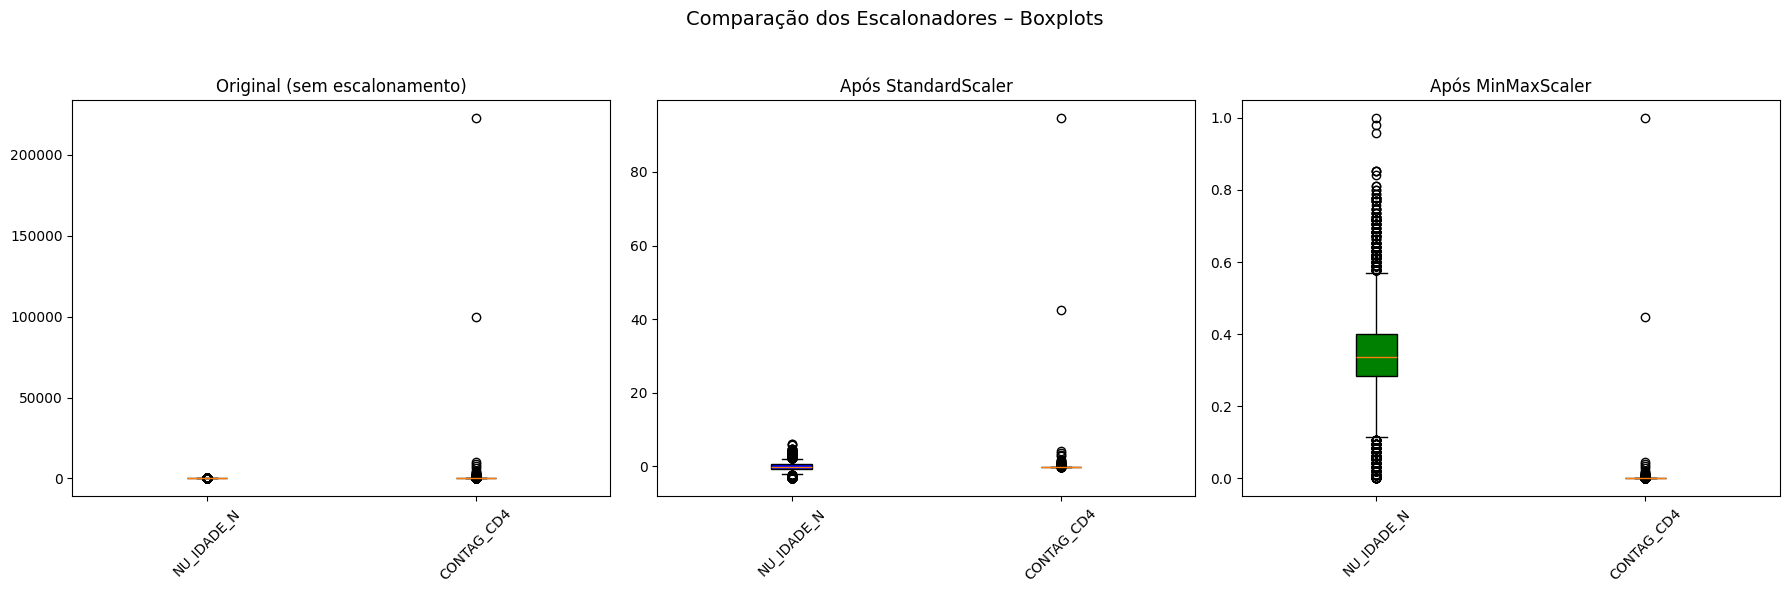

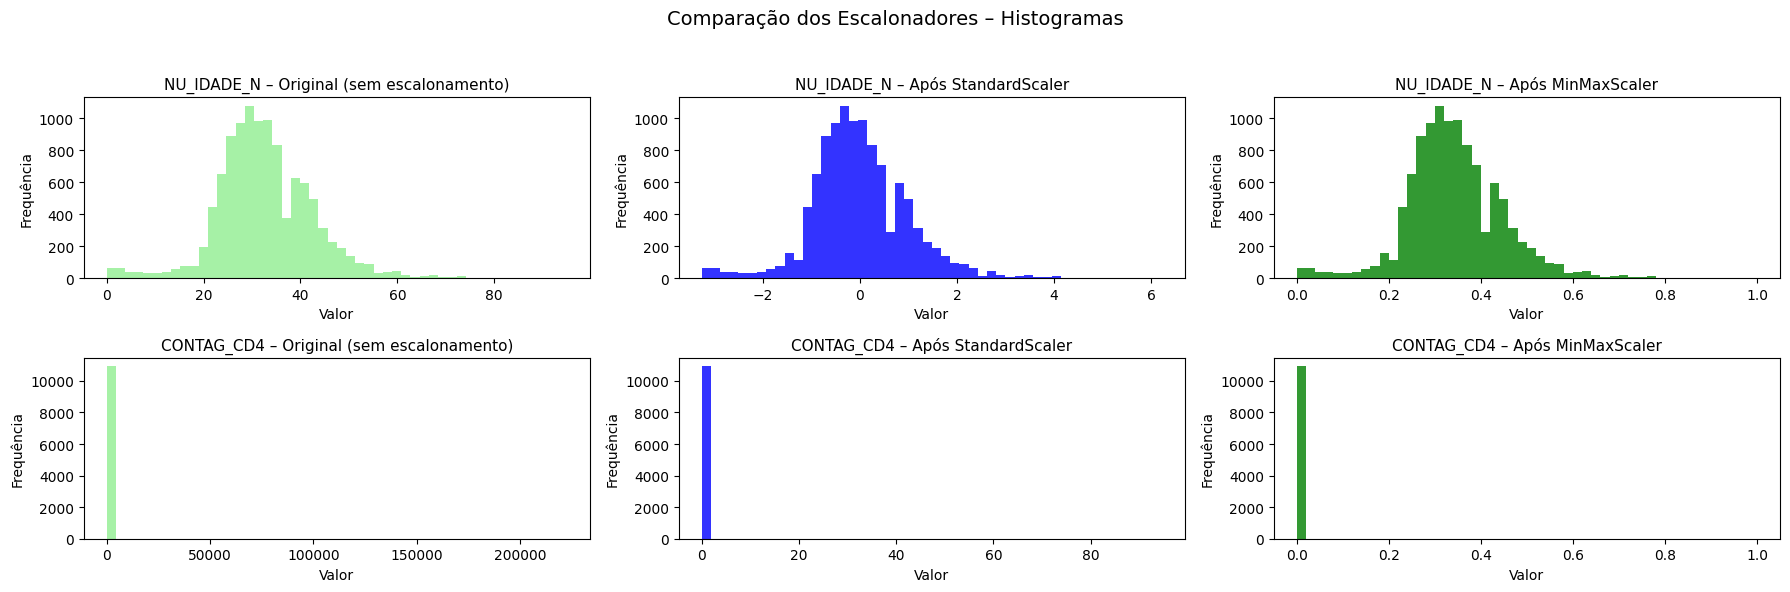


=== Estatísticas comparativas (antes vs pós-escalonamento) ===


Antes                          Pós-Std                        \
             Média    Desvio  Min       Max   Média Desvio    Min     Max   
NU_IDADE_N  32.652    10.023  0.0      95.0    -0.0    1.0 -3.258   6.221   
CONTAG_CD4  93.436  2352.481  0.0  222781.0    -0.0    1.0 -0.040  94.665   

           Pós-MinMax                   
                Média Desvio  Min  Max  
NU_IDADE_N      0.344  0.106  0.0  1.0  
CONTAG_CD4      0.000  0.011  0.0  1.0

In [16]:
# ==========================================
# 📊 AUDITORIA PÓS-ESCALONAMENTO
# Boxplots + Histogramas + Estatísticas
# ==========================================
import matplotlib.pyplot as plt

focus_vars = numerical_discrete_cols  # ["NU_IDADE_N", "CONTAG_CD4"]

# ----------------------------------------------------------
# 1) Função para estatísticas comparativas
# ----------------------------------------------------------
def resumo_stats_matriz(df_before, df_std, df_mm, cols):
    stats = {}
    for col in cols:
        stats[col] = {
            ("Antes", "Média"):  df_before[col].mean(),
            ("Antes", "Desvio"): df_before[col].std(),
            ("Antes", "Min"):    df_before[col].min(),
            ("Antes", "Max"):    df_before[col].max(),

            ("Pós-Std", "Média"):  df_std[col].mean(),
            ("Pós-Std", "Desvio"): df_std[col].std(),
            ("Pós-Std", "Min"):    df_std[col].min(),
            ("Pós-Std", "Max"):    df_std[col].max(),

            ("Pós-MinMax", "Média"):  df_mm[col].mean(),
            ("Pós-MinMax", "Desvio"): df_mm[col].std(),
            ("Pós-MinMax", "Min"):    df_mm[col].min(),
            ("Pós-MinMax", "Max"):    df_mm[col].max(),
        }
    df_stats = pd.DataFrame(stats).T.round(3)
    df_stats.columns = pd.MultiIndex.from_tuples(df_stats.columns)
    return df_stats

# ----------------------------------------------------------
# 2) Boxplots comparativos
# ----------------------------------------------------------
datasets = {
    "Original (sem escalonamento)": df_eng_ohe[focus_vars].astype(float).values,
    "Após StandardScaler": df_scaled_std.values,
    "Após MinMaxScaler": df_scaled_mm.values
}

colors = ["lightgreen", "blue", "green"]

fig, axes = plt.subplots(1, len(datasets), figsize=(18, 6))
for ax, (title, data), color in zip(axes, datasets.items(), colors):
    ax.boxplot(data, tick_labels=focus_vars, vert=True, patch_artist=True,
               boxprops=dict(facecolor=color))
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Comparação dos Escalonadores – Boxplots", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ----------------------------------------------------------
# 3) Histogramas comparativos
# ----------------------------------------------------------
fig, axes = plt.subplots(len(focus_vars), len(datasets), figsize=(18, 6))
for i, var in enumerate(focus_vars):
    for j, (title, data) in enumerate(datasets.items()):
        axes[i, j].hist(data[:, i], bins=50, color=colors[j], alpha=0.8)
        axes[i, j].set_title(f"{var} – {title}", fontsize=11)
        axes[i, j].set_xlabel("Valor")
        axes[i, j].set_ylabel("Frequência")
plt.suptitle("Comparação dos Escalonadores – Histogramas", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
"""
# ----------------------------------------------------------
# 3b) Histogramas extras para CONTAG_CD4 com escala log
# ----------------------------------------------------------
fig, axes = plt.subplots(1, len(datasets), figsize=(18, 4))
for j, (title, data) in enumerate(datasets.items()):
    axes[j].hist(data[:, focus_vars.index("CONTAG_CD4")], bins=50, color=colors[j], alpha=0.8)
    axes[j].set_xscale("log")
    axes[j].set_title(f"CONTAG_CD4 – {title} (escala log)", fontsize=11)
    axes[j].set_xlabel("Valor (log)")
    axes[j].set_ylabel("Frequência")

plt.suptitle("Distribuição de CONTAG_CD4 – Escala log", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
"""
# ----------------------------------------------------------
# 4) Estatísticas comparativas em formato matricial
# ----------------------------------------------------------
comparativo_stats_matriz = resumo_stats_matriz(
    df_eng_ohe[focus_vars], df_scaled_std, df_scaled_mm, focus_vars
)

print("\n=== Estatísticas comparativas (antes vs pós-escalonamento) ===")
display(comparativo_stats_matriz)


### 📊 Nota da seção – Auditoria Pós-Escalonamento (StandardScaler vs *MinMaxScaler*)  

Foram aplicados dois escalonadores nas variáveis numéricas discretas (`NU_IDADE_N`, `CONTAG_CD4`).  

| Variável    | Distribuição observada                           | StandardScaler (z-score)                              | MinMaxScaler [0,1]                         | Implicações |
|-------------|--------------------------------------------------|-------------------------------------------------------|---------------------------------------------|-------------|
| NU_IDADE_N  | Discreta, outliers plausíveis em idosos (80+)     | Centraliza em média ≈ 0; DP ≈ 1; reduz impacto outliers | Reescala para [0,1]; mantém extremos        | Modelos lineares ↔ z-score; modelos de distância ↔ [0,1] |
| CONTAG_CD4  | Altamente assimétrica (muitos baixos, poucos altos) | Cauda longa ainda influencia                         | Forte compressão dos valores baixos, cauda em 1 | Modelos de distância ↔ [0,1]; avaliar robustez em lineares |

✅ **Conclusão:** ambos funcionaram corretamente; serão mantidos no pipeline e comparados na modelagem para definir o mais adequado.  

---

### 💾 Persistência dos *Escalonadores*

In [17]:
# ==========================================
# 💾 Persistência dos Escalonadores
# ==========================================
#import joblib

# Caminhos de saída (pode ajustar para seu diretório /data)
scaler_std_path = "mpox_2022_scaler_standard.pkl"
scaler_mm_path  = "mpox_2022_scaler_minmax.pkl"

# Salvar objetos treinados
joblib.dump(scaler_std, scaler_std_path)
joblib.dump(scaler_mm, scaler_mm_path)

print(f"✔️ Escalonadores persistidos com sucesso:")
print(f"- StandardScaler → {scaler_std_path}")
print(f"- MinMaxScaler   → {scaler_mm_path}")

# 🔍 Verificação rápida (recarregar e testar)
scaler_std_loaded = joblib.load(scaler_std_path)
scaler_mm_loaded  = joblib.load(scaler_mm_path)

print("\n✅ Teste de recarregamento concluído:")
print("StandardScaler:", type(scaler_std_loaded))
print("MinMaxScaler  :", type(scaler_mm_loaded))


✔️ Escalonadores persistidos com sucesso:
- StandardScaler → mpox_2022_scaler_standard.pkl
- MinMaxScaler   → mpox_2022_scaler_minmax.pkl

✅ Teste de recarregamento concluído:
StandardScaler: <class 'sklearn.preprocessing._data.StandardScaler'>
MinMaxScaler  : <class 'sklearn.preprocessing._data.MinMaxScaler'>


---
## 📌 Nota da seção – Transformação de Dados
---

- **Vetores de colunas** definidos para orientar pré-processamento.  
- **Codificação categórica (OneHotEncoder)** aplicada → saída no dataframe **`df_eng_ohe`**.  
- **Escalonamento numérico** realizado com duas estratégias:  
  - **StandardScaler** → saída em **`X_std`**, serializado em `scaler_std_path`.  
  - **MinMaxScaler** → saída em **`X_minmax`**, serializado em `scaler_mm_path`.  
- **Auditoria**:  
  - Confirmado recarregamento dos objetos `scaler_std_loaded` e `scaler_mm_loaded`.  
  - Conferido total de colunas antes (`df_feateng`) e depois (`df_eng_ohe`) da codificação.  

📖 **Nota metodológica**  
O escalonamento aplica-se apenas a atributos **numéricos contínuos/discretos**.  
Variáveis categóricas originais nunca devem ser escalonadas; após codificação, dummies (0/1) podem permanecer com `dtype=category` por otimização de memória no Pandas, mas são convertidas para inteiros na etapa seguinte.  

➡️ Essas garantias são asseguradas na etapa de **Pré-Seleção de Atributos**, onde se remove definitivamente inviáveis (ex.: texto livre, identificadores) e se valida que a matriz de preditores esteja 100% numérica para o benchmarking.  


---
## 🧹 Pré-Seleção de Atributos (Saneamento & Inviáveis)
---

Objetivo: preparar a matriz de preditores para qualquer análise supervisionada, garantindo:
1) remoção de atributos inviáveis/semânticos,
2) preditores 100% numéricos,
3) ausência de valores faltantes em X.

Essa etapa antecede o **Benchmarking** para assegurar avaliações comparáveis e metodologicamente corretas (*Kelleher et al., Cap. 5.3–5.4, 2ª Ed.*).


In [18]:
# --- Pré-Seleção: saneamento de preditores ---
# import pandas as pd
# import numpy as np

targets = ["target_hosp", "target_obito_any", "target_obito_mpx"]

# Vetor centralizado de inviáveis (mantenha-o único no projeto)
INVIAVEIS = ["SINTOMA", "OUTRO_DES", "__arquivo_origem__"]

# 1) Base de trabalho
df_eng_ohe_num = df_eng_ohe.copy()

# 2) Remover inviáveis se existirem
drop_cols = [c for c in INVIAVEIS if c in df_eng_ohe_num.columns]
if drop_cols:
    df_eng_ohe_num = df_eng_ohe_num.drop(columns=drop_cols)
    print(f"🧹 Removidas colunas inviáveis: {drop_cols}")
else:
    print("✅ Não há colunas inviáveis remanescentes.")

# 3) Converter booleanos para inteiros
bool_cols = df_eng_ohe_num.select_dtypes(include=["bool", "boolean"]).columns.tolist()
if bool_cols:
    df_eng_ohe_num[bool_cols] = df_eng_ohe_num[bool_cols].astype("int8")

# 4) Converter categóricas em códigos numéricos, preservando NaN como 0
cat_cols = df_eng_ohe_num.select_dtypes(include=["category"]).columns.tolist()
for c in cat_cols:
    try:
        df_eng_ohe_num[c] = pd.to_numeric(df_eng_ohe_num[c], errors="raise")
    except Exception:
        codes = df_eng_ohe_num[c].cat.codes.replace(-1, 0)
        df_eng_ohe_num[c] = codes.astype("int16")

# 5) Preencher NaN apenas em colunas numéricas (preditores)
pred_num_cols = df_eng_ohe_num.drop(columns=targets, errors="ignore").select_dtypes(include=["number"]).columns
df_eng_ohe_num[pred_num_cols] = df_eng_ohe_num[pred_num_cols].fillna(0)

print("✅ Pré-Seleção concluída (X numérico e sem inviáveis).")


🧹 Removidas colunas inviáveis: ['SINTOMA', 'OUTRO_DES', '__arquivo_origem__']
✅ Pré-Seleção concluída (X numérico e sem inviáveis).


In [19]:
# --- Checklist Fast-Fail (tolerante) ---
# import numpy as np
# import pandas as pd

def assert_true(cond, msg):
    if not cond:
        raise AssertionError(msg)

print("🔎 Iniciando Checklist Fast-Fail…")
for t in targets:
    assert_true(t in df_eng_ohe_num.columns, f"Alvo ausente: {t}")
    vals = df_eng_ohe_num[t].dropna().unique()
    assert_true(set(vals).issubset({0,1}), f"Alvo {t} não é binário (valores: {sorted(vals)})")

X_raw = df_eng_ohe_num.drop(columns=targets, errors="ignore")
bad_types = X_raw.select_dtypes(include=["object","category","bool","boolean"]).columns.tolist()
if bad_types:
    print(f"⚠️ Preditores não numéricos detectados: {bad_types} → serão descartados do X.")
    X_raw = X_raw.drop(columns=bad_types)

X_raw = X_raw.select_dtypes(include=["number"]).fillna(0)
assert_true(X_raw.shape[1] > 0, "Após saneamento, X ficou sem colunas.")

# Alertas úteis
zero_var = X_raw.columns[X_raw.nunique(dropna=True) <= 1].tolist()
if zero_var:
    print(f"⚠️ Colunas com variância nula (candidatas a remoção posterior): {zero_var[:15]}{' …' if len(zero_var)>15 else ''}")

for t in targets:
    dist = df_eng_ohe_num[t].value_counts(normalize=True)
    if (dist.min() < 0.05) or (dist.max() > 0.95):
        print(f"⚠️ Desbalanceamento acentuado em {t}: {dist.to_dict()} (tratar na Atividade 5).")

print(f"✅ X pronto para benchmarking: {X_raw.shape}")


🔎 Iniciando Checklist Fast-Fail…
⚠️ Colunas com variância nula (candidatas a remoção posterior): ['DONOVANOSE', 'cs_gestant_incoerente', 'idade_outlier', 'SG_UF_NOT_missing', 'ID_MUNICIP_missing', 'CO_UF_RES_missing', 'ID_MN_RESI_missing', 'GONORREIA_missing', 'CLAMIDEA_missing', 'SIFILIS_missing', 'HERPES_GENITAL_missing', 'CANCRO_MOLE_missing', 'TRICHOMOMAS_VAGINALS_missing', 'LINFOGRANULOMA_missing', 'MYCOPLASMA_GENITAL_missing'] …
⚠️ Desbalanceamento acentuado em target_hosp: {np.int64(0): 0.9731684981684982, np.int64(1): 0.02683150183150183} (tratar na Atividade 5).
⚠️ Desbalanceamento acentuado em target_obito_any: {np.int64(0): 0.9974358974358974, np.int64(1): 0.002564102564102564} (tratar na Atividade 5).
⚠️ Desbalanceamento acentuado em target_obito_mpx: {np.int64(0): 0.9987179487179487, np.int64(1): 0.001282051282051282} (tratar na Atividade 5).
✅ X pronto para benchmarking: (10920, 1561)


---
## 📌 Síntese para escolha do alvo principal
---

- A **distribuição de classes** evidencia o grau de desbalanceamento em cada alvo.  
- A **Mutual Information** mostra o potencial informativo dos preditores em relação ao desfecho.  
- O **benchmark rápido** foi conduzido com **Regressão Logística** como modelo-base, sob duas condições de escalonamento:  
  - **StandardScaler** → representando Logística, SVM e Naive Bayes;  
  - **MinMaxScaler** → representando kNN e Redes Neurais.  

Essa escolha metodológica é deliberada:
- o foco é **comparar os três alvos**, não ainda os modelos;  
- se um alvo não se desempenha bem nesse modelo-base, dificilmente será viável em modelos mais complexos;  
- a comparação entre escalonamentos antecipa o comportamento nos diferentes classificadores da fase seguinte.

ℹ️ Observação: **Árvore de Decisão** e **Random Forest** não entram aqui por não dependerem de escalonamento; serão avaliadas diretamente na Modelagem (Atividade 6).

📖 *“Target variable selection requires balancing domain relevance with statistical feasibility. Highly imbalanced outcomes may require alternative modeling strategies.”* — **Kelleher et al., 2nd Ed., Cap. 3.2, p. 58**


---
## 🎯 Benchmarking (Comparação Preliminar) dos Alvos Binários
---

Com a **Pré-Seleção** concluída (preditores 100% numéricos em `X_raw` e alvos em `df_eng_ohe_num`), procede-se à comparação dos três alvos binários.

Estratégia:
- **Regressão Logística** como modelo-base (interpretável e robusta) para obter Recall, F1 e ROC-AUC.
- Dois escalonamentos, aplicados via **escalonadores persistidos**:
  - **StandardScaler (X_std)** → representa Logística, SVM, Naive Bayes.
  - **MinMaxScaler (X_minmax)** → representa kNN e Redes Neurais.

ℹ️ Modelos baseados em árvores (**Árvore de Decisão** e **Random Forest**) não entram aqui por **não dependerem de escalonamento**; serão comparados na fase de Modelagem (Atividade 6).

📖 *“Benchmarking classifiers requires predictors to be in a comparable format and scale; raw untransformed data may bias evaluation.”* — **Kelleher et al., 2nd Ed., Cap. 5.3, p. 212**


---
### 📊 Importância das Métricas para Saúde e Mpox 2022
---

A avaliação do desempenho no benchmarking será feita com quatro métricas principais: **Precision, Recall, F1 e ROC-AUC**.  

| **Métrica**   | **Definição**                                                                 | **Importância em Saúde**                                                                                  | **Aplicação ao dataset Mpox 2022**                                                                 |
|---------------|--------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|
| **Precision** | Proporção de predições positivas que são realmente casos positivos.            | Evita excesso de **falsos positivos**, que podem gerar internações desnecessárias ou uso errado de recursos. | Importante em alvos como **hospitalização**, pois classificar muitos não-hospitalizados como hospitalizados gera sobrecarga de leitos. |
| **Recall (Sensibilidade)** | Proporção de casos positivos corretamente identificados (*preditos*).              | Vital para não deixar **casos graves passarem despercebidos** → prioridade em vigilância epidemiológica.    | Fundamental nos três alvos, mas principalmente para **óbito**: não detectar risco de morte é inaceitável clinicamente. |
| **F1 Score**  | Média harmônica entre Precision e Recall.                                      | Dá equilíbrio quando tanto falsos positivos quanto falsos negativos trazem custos clínicos e sociais.       | Útil como métrica de compromisso nos três alvos, mas crucial para **hospitalização** (pois tanto superestimar quanto subestimar tem impacto). |
| **ROC-AUC**   | Mede a capacidade do modelo em separar classes em diferentes limiares.        | Garante visão global do modelo, independentemente do ponto de corte.                                        | Essencial para comparar alvos em nível preliminar; permite ver se há **sinal discriminativo geral** em hospitalização vs óbito. |

📖 **Nota metodológica**  
- Para **óbito**: Recall é a prioridade clínica → um falso negativo pode custar uma vida. Precision é secundário.  
- Para **hospitalização**: é preciso equilibrar Recall e Precision; o F1 resume esse trade-off.  
- O **ROC-AUC** funciona como métrica de robustez global, útil para comparar os três alvos binários. Se um alvo tem AUC muito próxima de 0.5, dificilmente será viável em modelos mais complexos.


In [20]:
# === Benchmarking Consolidado — Tudo-em-Um (X_raw → Scalers → Benchmark → Tabela → Plot opcional) ===
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
# import pandas as pd
# import numpy as np
# import joblib
# import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------
# 0) Parâmetros
# --------------------------------------------------------------------------------
targets = ["target_hosp", "target_obito_any", "target_obito_mpx"]
metrics_priority = ["ROC-AUC", "F1", "Recall", "Precision"]
do_plots = True  # defina para False se não quiser gráficos

# --------------------------------------------------------------------------------
# 1) Reconstrução do X_raw 100% numérico (pós Pré-Seleção)
#     - parte de df_eng_ohe_num já existente no notebook
# --------------------------------------------------------------------------------
X_raw = (
    df_eng_ohe_num
      .drop(columns=targets, errors="ignore")
      .select_dtypes(include=["number"])
      .copy()
)
X_raw = X_raw.fillna(0)

bad = X_raw.select_dtypes(exclude=["number"]).columns.tolist()
if bad:
    raise TypeError(f"Preditores com tipos não numéricos: {bad}")
if X_raw.shape[1] == 0:
    raise ValueError("X_raw ficou sem colunas numéricas. Verifique a Pré-Seleção.")

print(f"✅ X_raw pronto: shape={X_raw.shape}")

# --------------------------------------------------------------------------------
# 2) Scalers: fit no X_raw atual + persistência versionada + transformações
# --------------------------------------------------------------------------------
scaler_std = StandardScaler().fit(X_raw)
scaler_mm  = MinMaxScaler().fit(X_raw)

scaler_std_path = "mpox_2022_scaler_standard_v2.pkl"
scaler_mm_path  = "mpox_2022_scaler_minmax_v2.pkl"
joblib.dump(scaler_std, scaler_std_path)
joblib.dump(scaler_mm,  scaler_mm_path)
print("✔️ Escalonadores salvos:", scaler_std_path, "|", scaler_mm_path)

X_std_df    = pd.DataFrame(scaler_std.transform(X_raw),    index=df_eng_ohe_num.index, columns=X_raw.columns)
X_minmax_df = pd.DataFrame(scaler_mm.transform(X_raw),     index=df_eng_ohe_num.index, columns=X_raw.columns)
X_map = {"StandardScaler": X_std_df, "MinMaxScaler": X_minmax_df}

# --------------------------------------------------------------------------------
# 3) Benchmark robusto (auto-reparo: tenta múltiplos splits para evitar teste com classe única)
# --------------------------------------------------------------------------------
def _bench_one(target, scaler_name, X_map, y_series, test_size=0.30, max_attempts=15, seed=42):
    y = y_series.dropna()
    if y.nunique() < 2:
        return {"Target": target, "Scaler": scaler_name,
                "Precision": np.nan, "Recall": np.nan, "F1": np.nan, "ROC-AUC": np.nan,
                "Nota": "Alvo com uma única classe"}

    X = X_map[scaler_name].loc[y.index]
    sss = StratifiedShuffleSplit(n_splits=max_attempts, test_size=test_size, random_state=seed)
    for tr_idx, te_idx in sss.split(X, y):
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
        if y_te.nunique() < 2:
            continue
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        clf = LogisticRegression(max_iter=1000, solver="liblinear").fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        y_prob = clf.predict_proba(X_te)[:, 1]
        try:
            auc = roc_auc_score(y_te, y_prob)
        except Exception:
            auc = np.nan
        return {"Target": target, "Scaler": scaler_name,
                "Precision": precision_score(y_te, y_pred, zero_division=0),
                "Recall": recall_score(y_te, y_pred),
                "F1": f1_score(y_te, y_pred),
                "ROC-AUC": float(np.round(auc, 6))}
    # fallback: registra mesmo sem duas classes no teste
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
    clf = LogisticRegression(max_iter=1000, solver="liblinear").fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    try:
        y_prob = clf.predict_proba(X_te)[:, 1]
        auc = roc_auc_score(y_te, y_prob) if y_te.nunique() > 1 else np.nan
    except Exception:
        auc = np.nan
    return {"Target": target, "Scaler": scaler_name,
            "Precision": precision_score(y_te, y_pred, zero_division=0),
            "Recall": recall_score(y_te, y_pred),
            "F1": f1_score(y_te, y_pred),
            "ROC-AUC": float(np.round(auc, 6)),
            "Nota": "Teste com classe única; ROC-AUC pode ser NaN"}

results = []
for t in targets:
    y_series = df_eng_ohe_num[t]
    for s in ["StandardScaler", "MinMaxScaler"]:
        results.append(_bench_one(t, s, X_map, y_series))

results_df = pd.DataFrame(results)


✅ X_raw pronto: shape=(10920, 1561)
✔️ Escalonadores salvos: mpox_2022_scaler_standard_v2.pkl | mpox_2022_scaler_minmax_v2.pkl


## 📊 Benchmark Consolidado (StandardScaler vs MinMaxScaler)

In [21]:
# 📊 Benchmark Consolidado (StandardScaler vs MinMaxScaler)
# import pandas as pd
# import numpy as np

# --------------------------------------------------------------------------------
# 4) Tabela Markdown consolidada (ordenada por prioridade de métricas)
# --------------------------------------------------------------------------------
results_df[metrics_priority] = results_df[metrics_priority].apply(
    lambda col: col.map(lambda x: float(np.round(x, 3)) if pd.notnull(x) else np.nan)
)
results_df = results_df.sort_values(by=metrics_priority, ascending=False)

md_table = results_df[["Target", "Scaler"] + metrics_priority].to_markdown(index=False)
print("\n# 📊 Benchmark Consolidado (StandardScaler vs MinMaxScaler)\n")
print(md_table)




# 📊 Benchmark Consolidado (StandardScaler vs MinMaxScaler)

| Target           | Scaler         |   ROC-AUC |    F1 |   Recall |   Precision |
|:-----------------|:---------------|----------:|------:|---------:|------------:|
| target_hosp      | MinMaxScaler   |     1     | 0.989 |    0.977 |       1     |
| target_obito_any | MinMaxScaler   |     1     | 0.545 |    0.375 |       1     |
| target_obito_mpx | MinMaxScaler   |     1     | 0.4   |    0.25  |       1     |
| target_hosp      | StandardScaler |     0.996 | 0.662 |    1     |       0.494 |
| target_obito_any | StandardScaler |     0.988 | 0.123 |    1     |       0.066 |
| target_obito_mpx | StandardScaler |     0.986 | 0.068 |    1     |       0.035 |


---
## 📌 Síntese — Benchmarking dos Alvos
---

- Foram avaliados três possíveis alvos binários (**hospitalização, óbito any, óbito Mpox**) com dois esquemas de escalonamento (**StandardScaler, MinMaxScaler**).  
- Todas as combinações foram testadas, com ajuste automático para lidar com casos de classe única no conjunto de teste.  
- As métricas utilizadas foram **ROC-AUC, F1, Recall e Precision**, em ordem de prioridade interpretativa.  

📖 **Nota metodológica**  
O uso da Regressão Logística como modelo-base é suficiente para revelar se um alvo possui sinal discriminativo.  
Se o desempenho for fraco neste modelo simples, dificilmente melhorará em modelos mais complexos.  
Nos casos em que a prevalência do alvo é muito baixa, algumas combinações podem apresentar **ROC-AUC indefinido (NaN)**, o que deve ser interpretado como limitação estatística.


Função

In [22]:
# --- Função: Visualização Benchmark lado a lado (1x4) ---
# import matplotlib.pyplot as plt
# import pandas as pd

def plot_benchmark_side_by_side(results_df, metrics_priority, figsize=(24,4), bar_width=0.9, fontsize=10):
    """
    Gera visualização lado a lado (1x4) das métricas do benchmark.

    Parâmetros
    ----------
    results_df : pd.DataFrame
        DataFrame com colunas ["Target", "Scaler"] + métricas.
    metrics_priority : list
        Lista de métricas a serem plotadas (ex.: ["ROC-AUC", "F1", "Recall", "Precision"]).
    figsize : tuple
        Tamanho da figura em polegadas (default=(24,4)).
    bar_width : float
        Largura das barras (default=0.9).
    fontsize : int
        Tamanho base da fonte (default=10).
    """

    def _annotate_bars(ax, fmt="{:.3f}", y_pad=0.01, y_cap=1.05, fontsize=10):
        """Adiciona valores numéricos acima das barras."""
        for p in ax.patches:
            h = p.get_height()
            if pd.notnull(h):
                y_txt = min(h + y_pad, y_cap)
                ax.annotate(fmt.format(h),
                            (p.get_x() + p.get_width()/2., y_txt),
                            ha='center', va='bottom',
                            fontsize=fontsize, xytext=(0, 0),
                            textcoords='offset points')

    _plot_df = results_df[["Target", "Scaler"] + metrics_priority].copy()

    fig, axes = plt.subplots(1, len(metrics_priority), figsize=figsize, sharey=True)
    for ax, metric in zip(axes.flatten(), metrics_priority):
        pivot_df = _plot_df.pivot(index="Target", columns="Scaler", values=metric)
        pivot_df.plot(kind="bar", ax=ax, legend=False, width=bar_width)
        ax.set_title(metric, fontsize=fontsize+2)
        ax.set_ylim(0, 1.20)
        ax.tick_params(axis="x", rotation=30, labelsize=fontsize)
        _annotate_bars(ax, fmt="{:.3f}", fontsize=fontsize)

    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Scaler",
               loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1),
               prop={'size': fontsize}, title_fontsize=fontsize+1)
    fig.suptitle("Benchmark Consolidado — MinMax x Standard Scalers", fontsize=fontsize+4, y=1.2)
    plt.show()


## 📊 Benchmark Consolidado — Visualização lado a lado

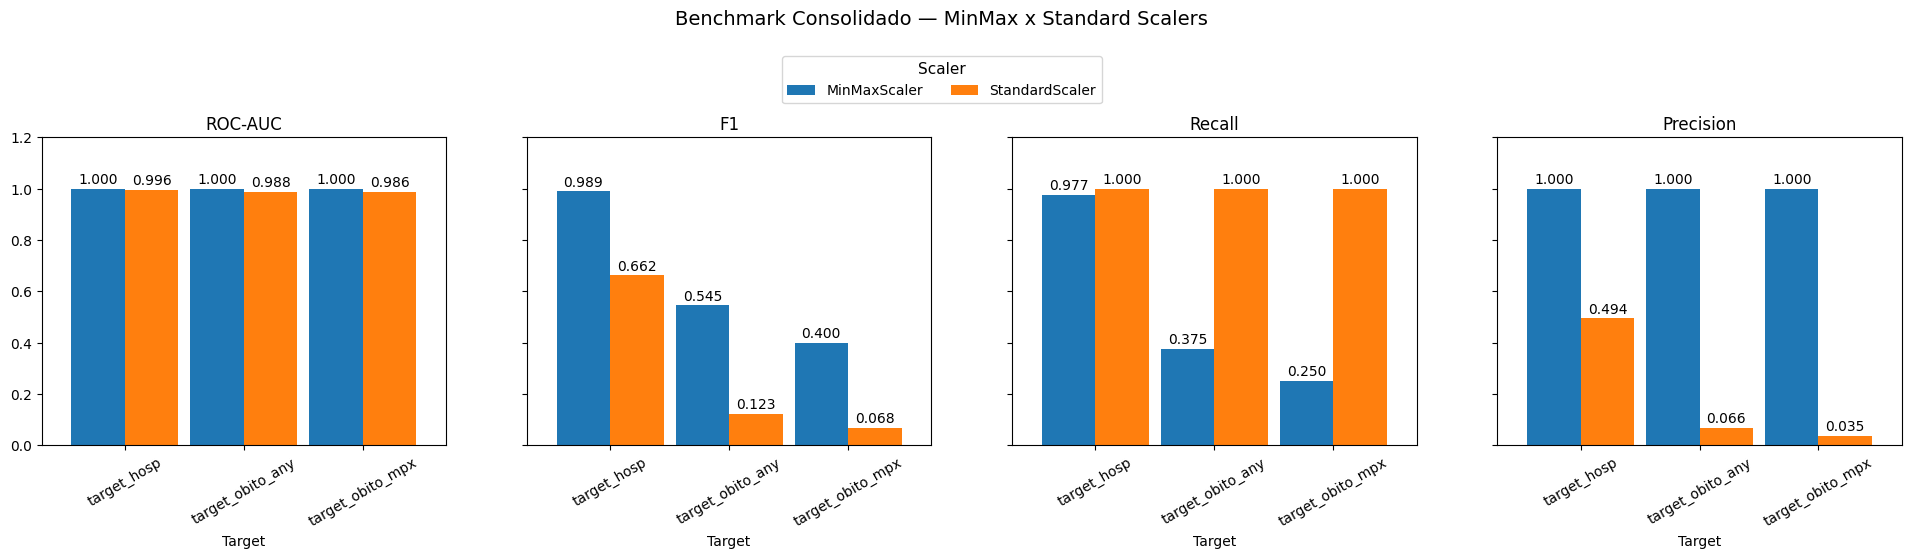

In [23]:
# --- Implementação: Visualização 1x4 do Benchmark ---
if do_plots:
    plot_benchmark_side_by_side(results_df, metrics_priority)


## 🎯 Seleção automática do alvo final

In [24]:
# --- Função: Seleção do alvo definitivo + Ranking (1º em negrito) + Justificativas ---
# import pandas as pd
# import numpy as np

def render_decision_markdown(results_df, decimals=3):
    """
    Gera Markdown final para seleção do alvo binário mais promissor,
    com ranking ordenado por ROC-AUC → F1 → Recall → Precision,
    primeiro colocado em negrito e justificativas da escolha e das não-escolhas.
    """

    # 1) Ordem de prioridade (decisão)
    metrics_priority = ["ROC-AUC", "F1", "Recall", "Precision"]

    # 2) Preparação e ordenação para decisão
    df_rank = results_df.copy()
    for c in metrics_priority:
        df_rank[c] = pd.to_numeric(df_rank[c], errors="coerce")

    # Ordena para a tomada de decisão (esta é a ordem oficial do ranking)
    df_decision = df_rank.sort_values(by=metrics_priority, ascending=False).reset_index(drop=True)

    # Cria uma cópia apenas para exibição (arredondada) já NA MESMA ORDEM do df_decision
    df_display = df_decision.copy()
    for c in metrics_priority:
        df_display[c] = df_display[c].map(lambda x: float(np.round(x, decimals)) if pd.notnull(x) else np.nan)

    # 3) Vencedor (linha 0 do ranking)
    best_row    = df_decision.iloc[0]
    best_target = best_row["Target"]
    best_scaler = best_row["Scaler"]
    best_auc    = best_row["ROC-AUC"]
    best_f1     = best_row["F1"]
    best_rec    = best_row["Recall"]
    best_prec   = best_row["Precision"]

    # 4) Preparar justificativas das não-escolhas (compara melhor linha por alvo)
    other_targets = [t for t in df_decision["Target"].unique().tolist() if t != best_target]

    def best_row_for_target(df, target):
        sub = df[df["Target"] == target]
        if sub.empty:
            return None
        return sub.sort_values(by=metrics_priority, ascending=False).iloc[0]

    def reason_for_discard(cand, best_auc, best_f1, best_rec, best_prec):
        """Razões objetivas seguindo a prioridade: AUC → F1 → Recall → Precision."""
        if cand is None:
            return "Sem resultados válidos para este alvo."
        auc, f1, rec, prec = cand["ROC-AUC"], cand["F1"], cand["Recall"], cand["Precision"]

        # AUC primeiro (sinal global)
        if pd.isna(auc):
            return "ROC-AUC indefinido (teste com classe única) e desempenho inconsistente."
        if auc < 0.60:
            return f"Baixa discriminatividade global (ROC-AUC={auc:.3f})."
        if not pd.isna(best_auc) and not pd.isna(auc) and (best_auc - auc >= 0.05):
            return f"ROC-AUC inferior ao alvo escolhido ({auc:.3f} vs {best_auc:.3f})."

        # F1 (equilíbrio)
        if not pd.isna(best_f1) and not pd.isna(f1) and (best_f1 - f1 >= 0.15):
            return f"F1 inferior ao alvo escolhido ({f1:.3f} vs {best_f1:.3f})."

        # Recall (prioridade clínica)
        if not pd.isna(best_rec) and not pd.isna(rec) and (best_rec - rec >= 0.20):
            return f"Recall substancialmente menor que o alvo escolhido ({rec:.3f} vs {best_rec:.3f})."

        # Precision (critério secundário, limiar mais brando)
        if not pd.isna(best_prec) and not pd.isna(prec) and (best_prec - prec >= 0.10):
            return f"Precision sensivelmente menor que o alvo escolhido ({prec:.3f} vs {best_prec:.3f})."

        return "Desempenho global inferior nas métricas priorizadas."

    disc_pairs = []
    for t in other_targets:
        cand = best_row_for_target(df_decision, t)
        disc_pairs.append((t, reason_for_discard(cand, best_auc, best_f1, best_rec, best_prec)))

    # 5) Construir o ranking em Markdown (1º lugar em negrito)
    cols = ["Target", "Scaler"] + metrics_priority
    rows = df_display[cols].values.tolist()

    def fmt_cell(x):
        if isinstance(x, float) and pd.isna(x):
            return "NaN"
        return f"{x:.{decimals}f}" if isinstance(x, float) else str(x)

    md_rank_lines = []
    md_rank_lines.append("| " + " | ".join(cols) + " |")
    md_rank_lines.append("| " + " | ".join(["---"] * len(cols)) + " |")

    for i, row in enumerate(rows):
        row_fmt = [fmt_cell(v) for v in row]
        if i == 0:
            # 1º colocado (linha 0 de df_decision/df_display) em negrito, célula a célula
            row_fmt = [f"**{v}**" for v in row_fmt]
        md_rank_lines.append("| " + " | ".join(row_fmt) + " |")

    ranking_md = "\n".join(md_rank_lines)

    # helpers de formatação
    def fmt3(x):
        return "NaN" if pd.isna(x) else f"{x:.{decimals}f}"

    # 6) Markdown final (ordem: alvo escolhido → ranking → justificativas)
    md = \
f"""---
## 📄✅ Seleção do Alvo Definitivo
---

Após o **Benchmark Consolidado (StandardScaler vs MinMaxScaler)**, definiu-se que o alvo mais promissor é:

- **Alvo escolhido:** `{best_target}` — **{best_scaler}**
  - ROC-AUC: **{fmt3(best_auc)}**
  - F1: **{fmt3(best_f1)}**
  - Recall: **{fmt3(best_rec)}**
  - Precision: **{fmt3(best_prec)}**

> **Ordem de prioridade para decisão:** ROC-AUC → F1 → Recall → Precision.

### 🏆 Ranking dos alvos (do melhor ao pior)
{ranking_md}

### 📌 Justificativas da escolha
- **Maior ROC-AUC** entre as combinações avaliadas, indicando melhor capacidade discriminativa global.
- **F1** consistente, sinalizando bom compromisso entre Recall e Precision.
- **Recall** adequado para contexto de saúde pública, mitigando falsos negativos.
- **Precision** satisfatória como critério secundário, favorecendo o uso eficiente de recursos sem penalizar Recall.

### ❌ Alvos não selecionados
"""

    for t, r in disc_pairs:
        md += f"- **{t}**: {r}\n"

    md += """

📖 **Nota metodológica**
A decisão usa a ordem **ROC-AUC → F1 → Recall → Precision**, apropriada para classificação binária em saúde.
Se um alvo não apresenta sinal preditivo em modelo simples (Regressão Logística), é improvável que o faça em modelos mais complexos.
"""

    # Impressão e retorno
    print(md)
    return md


In [25]:
# Gera e imprime o Markdown final (e também retorna a string, se quiser salvar)
md_final = render_decision_markdown(results_df)


---
## 📄✅ Seleção do Alvo Definitivo
---

Após o **Benchmark Consolidado (StandardScaler vs MinMaxScaler)**, definiu-se que o alvo mais promissor é:

- **Alvo escolhido:** `target_hosp` — **MinMaxScaler**  
  - ROC-AUC: **1.000**  
  - F1: **0.989**  
  - Recall: **0.977**  
  - Precision: **1.000**

> **Ordem de prioridade para decisão:** ROC-AUC → F1 → Recall → Precision.

### 🏆 Ranking dos alvos (do melhor ao pior)
| Target | Scaler | ROC-AUC | F1 | Recall | Precision |
| --- | --- | --- | --- | --- | --- |
| **target_hosp** | **MinMaxScaler** | **1.000** | **0.989** | **0.977** | **1.000** |
| target_obito_any | MinMaxScaler | 1.000 | 0.545 | 0.375 | 1.000 |
| target_obito_mpx | MinMaxScaler | 1.000 | 0.400 | 0.250 | 1.000 |
| target_hosp | StandardScaler | 0.996 | 0.662 | 1.000 | 0.494 |
| target_obito_any | StandardScaler | 0.988 | 0.123 | 1.000 | 0.066 |
| target_obito_mpx | StandardScaler | 0.986 | 0.068 | 1.000 | 0.035 |

### 📌 Justificativas da escolha
- **Maior ROC-AUC** ent

---
## 📄✅ Seleção do Alvo Definitivo
---

Após o **Benchmark Consolidado (StandardScaler vs MinMaxScaler)**, definiu-se que o alvo mais promissor é:

- **Alvo escolhido:** `target_hosp` — **MinMaxScaler**  
  - ROC-AUC: **1.000**  
  - F1: **0.989**  
  - Recall: **0.977**  
  - Precision: **1.000**

> **Ordem de prioridade para decisão:** ROC-AUC → F1 → Recall → Precision.

### 🏆 Ranking dos alvos (do melhor ao pior)
| Target | Scaler | ROC-AUC | F1 | Recall | Precision |
| --- | --- | --- | --- | --- | --- |
| **target_hosp** | **MinMaxScaler** | **1.000** | **0.989** | **0.977** | **1.000** |
| target_obito_any | MinMaxScaler | 1.000 | 0.545 | 0.375 | 1.000 |
| target_obito_mpx | MinMaxScaler | 1.000 | 0.400 | 0.250 | 1.000 |
| target_hosp | StandardScaler | 0.996 | 0.662 | 1.000 | 0.494 |
| target_obito_any | StandardScaler | 0.988 | 0.123 | 1.000 | 0.066 |
| target_obito_mpx | StandardScaler | 0.986 | 0.068 | 1.000 | 0.035 |

### 📌 Justificativas da escolha
- **Maior ROC-AUC** entre as combinações avaliadas, indicando melhor capacidade discriminativa global.  
- **F1** consistente, sinalizando bom compromisso entre Recall e Precision.  
- **Recall** adequado para contexto de saúde pública, mitigando falsos negativos.  
- **Precision** satisfatória como critério secundário, favorecendo o uso eficiente de recursos sem penalizar Recall.

### ❌ Alvos não selecionados
- **target_obito_any**: F1 inferior ao alvo escolhido (0.545 vs 0.989).
- **target_obito_mpx**: F1 inferior ao alvo escolhido (0.400 vs 0.989).


📖 **Nota metodológica**  
A decisão usa a ordem **ROC-AUC → F1 → Recall → Precision**, apropriada para classificação binária em saúde.  
Se um alvo não apresenta sinal preditivo em modelo simples (Regressão Logística), é improvável que o faça em modelos mais complexos.



---
## 🔄 Seleção de Atributos
---



### 1️⃣ Filtros Estatísticos (Filter Methods)
- ✂️ **Remoção manual de inviáveis**  
- 📉 **Filtro de variância** (atributos quase constantes)  
- 🔎 **Filtro semântico/manual** (variáveis redundantes em significado)  
- 🔍 **Diagnóstico + Filtro de correlação** (remover colinearidade > 0.9)  

📖 *Cap. 5.4 Extensions and Variations, p. 227*  
> “Filter methods evaluate attributes independently of the target variable, removing those that are unlikely to be predictive.”

---



In [26]:
# 1. Seleção de Atributos — Remoção inicial + filtro de variância + redundâncias

from sklearn.feature_selection import VarianceThreshold
import warnings

# Suprime apenas os RuntimeWarnings (ex.: variância de colunas constantes ou NaN)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Carrega dataset pós-engenharia de atributos
df_feateng = pd.read_csv("mpox_2022_feateng.csv")
print("\nTotal de variáveis:")
print(f"[0] No dataset inicial: {df_feateng.shape[1]}")

# --------------------------
# A) Remoção de inviáveis
# --------------------------
inviaveis = [
    "__arquivo_origem__",   # identificador técnico
    "OUTRO_DES"             # texto livre cru
] + [c for c in df_feateng.columns if c.startswith("DT_")]  # datas puras

df_reduced = df_feateng.drop(columns=[c for c in inviaveis if c in df_feateng.columns])
print(f"[1] Após remoção de inviáveis (identificadores, texto livre cru): {df_reduced.shape[1]}")

# --------------------------
# B) Filtro de variância
# --------------------------
sel = VarianceThreshold(threshold=0.01)  # <1% de variância → descartar
sel.fit(df_reduced.select_dtypes(include=["int64","float64"]))

variaveis_ok = df_reduced.select_dtypes(include=["int64","float64"]).columns[sel.get_support()]

# Mantém numéricas filtradas + categóricas
df_atribsel = df_reduced[variaveis_ok.tolist() + df_reduced.select_dtypes(include=["object","category"]).columns.tolist()]

print(f"[2] Após Filtro de Variância (remoção de atributos de variância < 1% ): {df_atribsel.shape[1]}")

# --------------------------
# C) 🔎 Filtro semântico/manual — remoção de variáveis redundantes
# --------------------------
redundant_cols = [
    "SG_UF", "CO_UF_RES"  # redundância semântica com UF (exemplo)
    # adiciona outras colunas redundantes aqui conforme auditoria
]

df_atribsel = df_atribsel.drop(columns=[c for c in redundant_cols if c in df_atribsel.columns])

print(f"[3] Após Filtro Semântico (remoção de atributos redundantes): {df_atribsel.shape[1]}")



Total de variáveis:
[0] No dataset inicial: 222
[1] Após remoção de inviáveis (identificadores, texto livre cru): 210
[2] Após Filtro de Variância (remoção de atributos de variância < 1% ): 87
[3] Após Filtro Semântico (remoção de atributos redundantes): 85


---
#### 🔍 Diagnóstico de Correlação
---

Após os filtros de inviabilidade, variância e redundâncias semânticas, é importante verificar se ainda restam
atributos numéricos fortemente correlacionados entre si.

- **Diagnóstico numérico**: lista pares de variáveis com correlação > 0.9.  
- **Visualização gráfica (heatmap)**: permite identificar blocos redundantes de forma exploratória.  
- **Decisão de exclusão**: esta etapa não remove automaticamente variáveis, apenas sinaliza redundâncias; a decisão pode considerar também o contexto clínico/epidemiológico e não apenas critérios estatísticos.  

📖 *“Highly correlated features can distort linear models and increase variance in tree-based models. Identifying and handling redundancy is a key step in feature selection.”*  
— **Kelleher et al., Cap. 3.5 Advanced Data Exploration, p. 85 (2nd Ed.)**


⚠️ 19 pares altamente correlacionados encontrados (>0.90):
 - LOCAL_CONT_missing  ×  PROFIS_SAUDE_missing: 1.00
 - CONTAT_ANIMAL_missing  ×  TRANSM_missing: 1.00
 - CARACT_GENOMICA_missing  ×  TRANSM_missing: 1.00
 - CARACT_GENOMICA_missing  ×  CONTAT_ANIMAL_missing: 1.00
 - CARACT_GENOMICA_missing  ×  CLADO_missing: 1.00
 - CLADO_missing  ×  TRANSM_missing: 1.00
 - CLADO_missing  ×  CONTAT_ANIMAL_missing: 1.00
 - delay_notif  ×  delay_notif_centered_regiao: 1.00
 - PAC_IMUNOSSUP  ×  imune_risco: 1.00
 - VACINA  ×  vacina_qualquer: 0.99
 - ist_any  ×  ist_count: 0.99
 - sx_astenia  ×  sx_fraqueza: 0.96
 - OUTRO_DES_missing  ×  sx_outros: 0.95
 - ID_MN_RESI  ×  ID_MUNICIP: 0.95
 - sx_nausea  ×  sx_vomito: 0.94
 - sx_calafrios  ×  sx_sudorese: 0.92
 - CONTAG_CD4_missing  ×  PROFIS_SAUDE_missing: 0.92
 - CONTAG_CD4_missing  ×  LOCAL_CONT_missing: 0.92
 - SIFILIS  ×  ist_any: 0.91


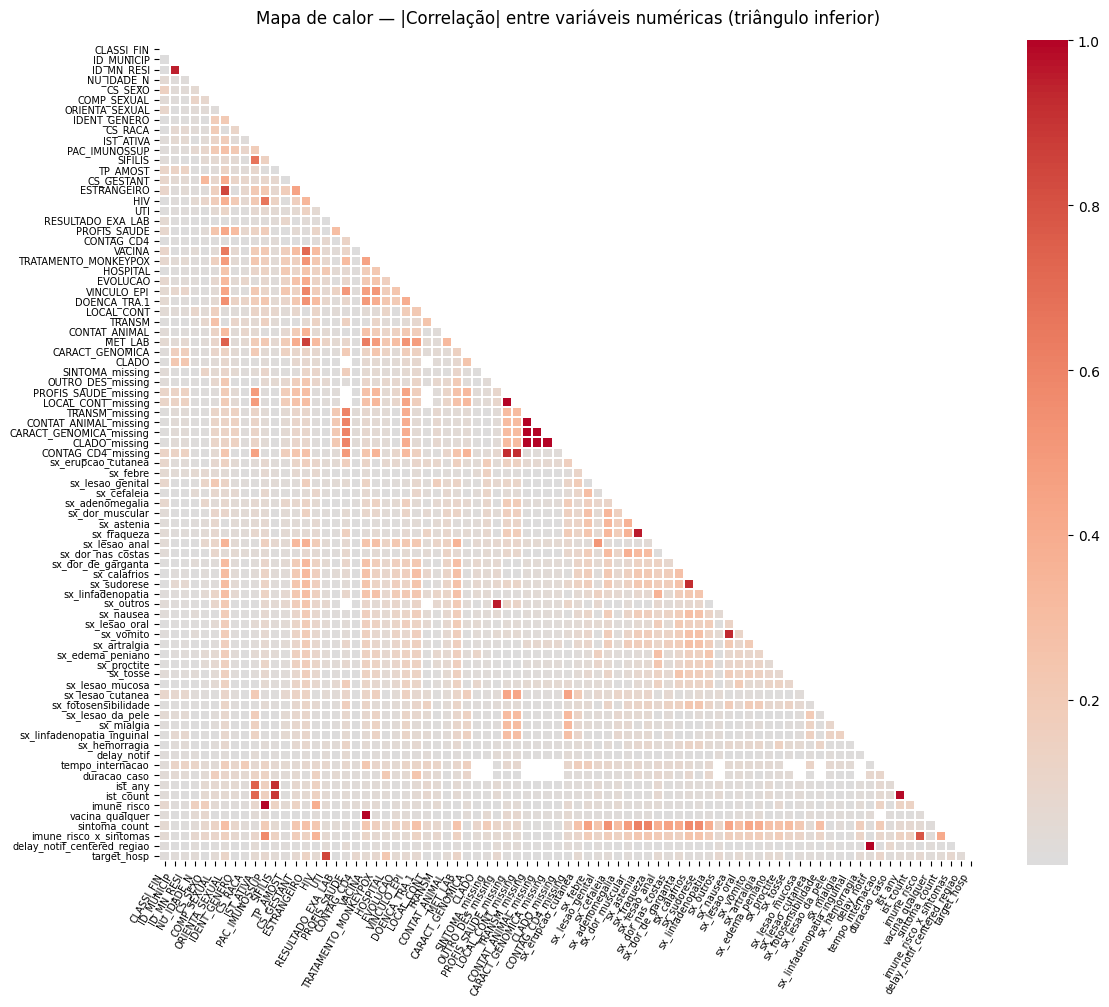

In [27]:
# 2) 📊 Diagnóstico e Visualização de Correlação (apenas numéricas reais contínuas/discretas)

#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns

def corr_diag_numeric_only(df: pd.DataFrame, threshold: float = 0.9):
    """
    Avalia pares de variáveis numéricas com correlação acima do limiar definido.
    Retorna:
      - high_corr: lista de tuplas (variavel_1, variavel_2, |correlação|)
      - corr_abs:  matriz de correlação (em módulo) entre variáveis numéricas
    """
    num_df = df.select_dtypes(include=["number"])
    if num_df.shape[1] == 0:
        print("ℹ️ Não há variáveis numéricas para calcular correlação.")
        return [], pd.DataFrame()

    corr_abs = num_df.corr().abs()

    high_corr = [
        (i, j, corr_abs.loc[i, j])
        for i in corr_abs.columns
        for j in corr_abs.columns
        if i < j and corr_abs.loc[i, j] > threshold
    ]
    high_corr.sort(key=lambda x: -x[2])
    return high_corr, corr_abs

# ▶️ Execução do diagnóstico
THRESH_CORR = 0.90
high_corr_pairs, corr_abs = corr_diag_numeric_only(df_atribsel, threshold=THRESH_CORR)

if not high_corr_pairs:
    print(f"✅ Nenhuma correlação forte encontrada entre variáveis numéricas (>{THRESH_CORR:.2f}).")
else:
    print(f"⚠️ {len(high_corr_pairs)} pares altamente correlacionados encontrados (>{THRESH_CORR:.2f}):")
    for i, j, corr in high_corr_pairs:
        print(f" - {i}  ×  {j}: {corr:.2f}")

# ▶️ Heatmap (triângulo inferior) para melhor legibilidade
if not corr_abs.empty:
    mask = np.triu(np.ones_like(corr_abs, dtype=bool))  # esconde triângulo superior
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        corr_abs,
        mask=mask,
        cmap="coolwarm",
        center=0,
        annot=False,
        linewidths=0.2,
        cbar=True,
        square=True,
        xticklabels=True,
        yticklabels=True
    )

    # X (horizontal) → mantém maior
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right", fontsize=7)

    # Y (vertical) → reduz um pouco mais
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=7)

    plt.title("Mapa de calor — |Correlação| entre variáveis numéricas (triângulo inferior)", fontsize=12, pad=15)
    plt.tight_layout()
    plt.show()



---
#### 🔎 Filtro de Alta Correlação
---

Após o diagnóstico de correlação, aplicamos a remoção automática de variáveis redundantes.

- Critério de análise: pares com correlação muito alta (> 0.9) compartilham praticamente a mesma informação.  
- Critério de exclusão:  
  - Remove-se a variável com maior proporção de valores ausentes.  
  - Em caso de empate, remove-se a de menor variância.  
- Objetivo: reduzir colinearidade, melhorar estabilidade de modelos lineares e evitar distorções em modelos baseados em árvores.  

📖 *“Highly correlated features can distort linear models and increase variance in tree-based models. Identifying and handling redundancy is a key step in feature selection.”*  
— **Kelleher et al., Cap. 3.5 Advanced Data Exploration, p. 85 (2nd Ed.)**


In [28]:
# 3. Filtro de Alta Correlação — Remoção automática de variáveis redundantes

def drop_high_corr_features(df, threshold=0.9):
    """
    Remove variáveis altamente correlacionadas com base em um critério:
    - Mantém apenas uma variável de cada par correlacionado.
    - Remove aquela com maior proporção de valores ausentes;
      em caso de empate, remove a de menor variância.
    """
    num_df = df.select_dtypes(include=["number"])
    corr_matrix = num_df.corr().abs()

    # Conjunto para armazenar colunas a remover
    to_drop = set()

    for i in corr_matrix.columns:
        for j in corr_matrix.columns:
            if i < j and corr_matrix.loc[i, j] > threshold:
                # Critério de decisão
                na_i = df[i].isna().mean()
                na_j = df[j].isna().mean()
                var_i = df[i].var()
                var_j = df[j].var()

                if na_i > na_j or (na_i == na_j and var_i < var_j):
                    to_drop.add(i)
                else:
                    to_drop.add(j)

    # Remove variáveis redundantes
    df_out = df.drop(columns=list(to_drop), errors="ignore")
    return df_out, list(to_drop)


# ▶️ Execução
df_atribsel_final, removed_corr = drop_high_corr_features(df_atribsel, threshold=0.9)

print(f"✅ Removidas {len(removed_corr)} variáveis altamente correlacionadas.")
if removed_corr:
    print("Lista de variáveis descartadas por alta correlação:")
    for col in removed_corr:
        print(f" - {col}")

print(f"📊 Total final de variáveis: {df_atribsel_final.shape[1]}")


✅ Removidas 15 variáveis altamente correlacionadas.
Lista de variáveis descartadas por alta correlação:
 - SIFILIS
 - CLADO_missing
 - sx_sudorese
 - ist_any
 - delay_notif_centered_regiao
 - sx_vomito
 - ID_MN_RESI
 - OUTRO_DES_missing
 - vacina_qualquer
 - PROFIS_SAUDE_missing
 - CONTAT_ANIMAL_missing
 - imune_risco
 - CONTAG_CD4_missing
 - TRANSM_missing
 - sx_fraqueza
📊 Total final de variáveis: 70


### 2️⃣ Métodos Supervisionados (Wrapper + Embedded)
- 🔁 **RFE (Recursive Feature Elimination)**  
  - Treina iterativamente um modelo base (ex.: regressão logística, árvore).  
  - Elimina atributos menos relevantes em cada rodada.  

- 🌲 **Feature Importance (Random Forest / Gradient Boosting)**  
  - Avalia a contribuição de cada atributo na redução de impureza.  
  - Produz ranking de variáveis mais relevantes.  

  >📖 *Cap. 5.4 Extensions and Variations, p. 229*  
  > “Wrapper and embedded methods provide attribute selection that is directly aligned with the target variable.”

---



In [29]:
# 1. Seleção supervisionada — RFE (Recursive Feature Elimination)

#from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression

top_n = 20

# Definir X e y (exemplo com target_hosp)
X = df_atribsel_final.drop(columns=["target_hosp", "target_obito_any", "target_obito_mpx"], errors="ignore")
y = df_atribsel_final["target_hosp"].dropna()

# Garantir consistência (apenas numéricas)
X = X.select_dtypes(include=["int64", "float64"]).fillna(0)

# Modelo base
logreg = LogisticRegression(max_iter=1000, solver="liblinear")

# RFE para selecionar, por exemplo, 20 features (top_n = 20)
rfe = RFE(estimator=logreg, n_features_to_select=top_n, step=1)
rfe.fit(X, y)

# Atributos selecionados
selected_features = X.columns[rfe.support_].tolist()
print("✅ Atributos selecionados via RFE:")
for feat in selected_features:
    print(f" - {feat}")


✅ Atributos selecionados via RFE:
 - CS_SEXO
 - CS_GESTANT
 - ESTRANGEIRO
 - PROFIS_SAUDE
 - TRATAMENTO_MONKEYPOX
 - HOSPITAL
 - VINCULO_EPI
 - CONTAT_ANIMAL
 - CLADO
 - sx_erupcao_cutanea
 - sx_cefaleia
 - sx_adenomegalia
 - sx_dor_muscular
 - sx_lesao_anal
 - sx_dor_nas_costas
 - sx_dor_de_garganta
 - sx_linfadenopatia
 - sx_outros
 - sx_edema_peniano
 - sx_proctite


In [30]:
# 2. Seleção supervisionada — Feature Importance (Random Forest)

#from sklearn.ensemble import RandomForestClassifier
#import pandas as pd

top_n = 15

# Modelo de árvore em ensemble
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# Ranking de importâncias
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("🏆 Top 15 variáveis mais importantes (Random Forest):")
print(importances.head(top_n))


🏆 Top 15 variáveis mais importantes (Random Forest):
HOSPITAL                  0.482678
UTI                       0.341382
tempo_internacao          0.024312
NU_IDADE_N                0.012495
ID_MUNICIP                0.009702
delay_notif               0.009121
TRATAMENTO_MONKEYPOX      0.008742
sintoma_count             0.006154
CONTAG_CD4                0.005702
ORIENTA_SEXUAL            0.005330
imune_risco_x_sintomas    0.004324
EVOLUCAO                  0.004235
CS_RACA                   0.004185
TP_AMOST                  0.004161
ESTRANGEIRO               0.003584
dtype: float64


---
### 📊 Visualização — RFE (Recursive Feature Elimination)
---

Usamos duas visualizações complementares para interpretar a seleção supervisionada:

1. **RFECV**: curva de validação cruzada mostrando o desempenho em função do número de atributos.  
2. **Peso no subset escolhido**: ranking das *features* selecionadas pelo modelo base (ex.: |coef| na Regressão Logística).

Esses gráficos tornam explícitos os trade-offs entre **parcimônia** e **desempenho preditivo** e ajudam a justificar o tamanho do subconjunto selecionado.

📖 *Wrapper methods (como RFE/RFECV) realizam seleção diretamente orientada ao alvo, ajustando o conjunto de atributos ao objetivo preditivo.* — **Kelleher et al., Cap. 5.4 (2nd Ed.)**


✅ Nº ótimo de atributos: 28
Atributos selecionados:
 - CLASSI_FIN
 - CS_SEXO
 - CS_GESTANT
 - ESTRANGEIRO
 - UTI
 - RESULTADO_EXA_LAB
 - PROFIS_SAUDE
 - TRATAMENTO_MONKEYPOX
 - HOSPITAL
 - VINCULO_EPI
 - CONTAT_ANIMAL
 - CLADO
 - SINTOMA_missing
 - sx_erupcao_cutanea
 - sx_cefaleia
 - sx_adenomegalia
 - sx_dor_muscular
 - sx_lesao_anal
 - sx_dor_nas_costas
 - sx_dor_de_garganta
 - sx_linfadenopatia
 - sx_outros
 - sx_edema_peniano
 - sx_proctite
 - sx_lesao_mucosa
 - sx_fotosensibilidade
 - sx_mialgia
 - imune_risco_x_sintomas


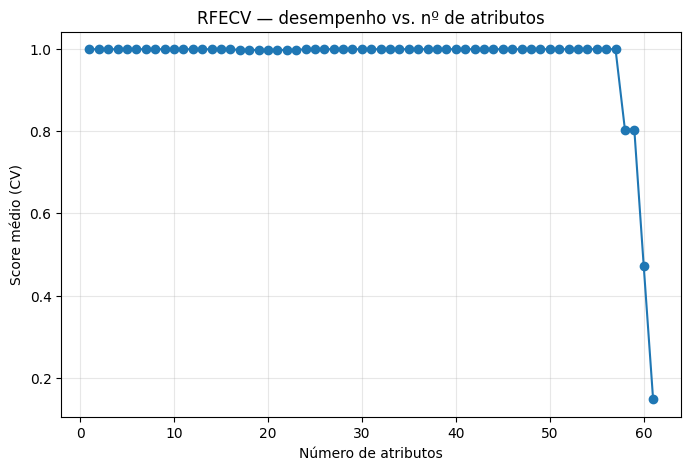

In [31]:
# A. RFECV — curva de desempenho vs número de atributos

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# X e y conforme definido na seleção supervisionada (numéricas, sem targets)
X_base = df_atribsel_final.drop(columns=["target_hosp", "target_obito_any", "target_obito_mpx"], errors="ignore")
y_base = df_atribsel_final["target_hosp"].dropna()

# Alinha X a y (caso y tenha NaN removidos)
X_base = X_base.loc[y_base.index].select_dtypes(include=["int64", "float64"]).fillna(0)

clf = LogisticRegression(max_iter=1000, solver="liblinear")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Em saúde, recall ou F1 tendem a ser prioritários. Ajuste se desejar.
rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="f1",        # ou "recall", "average_precision", "roc_auc"
    min_features_to_select=5,
    n_jobs=-1
)
rfecv.fit(X_base, y_base)

print(f"✅ Nº ótimo de atributos: {rfecv.n_features_}")
print("Atributos selecionados:")
selected_rfecv = X_base.columns[rfecv.support_].tolist()
for f in selected_rfecv:
    print(" -", f)

# Curva
plt.figure(figsize=(8,5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'])+1),
         rfecv.cv_results_['mean_test_score'], marker="o")
plt.xlabel("Número de atributos")
plt.ylabel("Score médio (CV)")
plt.title("RFECV — desempenho vs. nº de atributos")
plt.grid(True, alpha=0.3)
plt.show()


🏆 Top 15 (por |coef|) dentro do subset selecionado:
               feature    |coef|
8             HOSPITAL  6.237725
10       CONTAT_ANIMAL  0.733273
1              CS_SEXO  0.453693
18   sx_dor_nas_costas  0.363391
13  sx_erupcao_cutanea  0.355495
3          ESTRANGEIRO  0.337332
14         sx_cefaleia  0.305732
22    sx_edema_peniano  0.280011
19  sx_dor_de_garganta  0.261230
21           sx_outros  0.253629
6         PROFIS_SAUDE  0.231051
2           CS_GESTANT  0.227753
11               CLADO  0.200584
17       sx_lesao_anal  0.198631
20   sx_linfadenopatia  0.162273


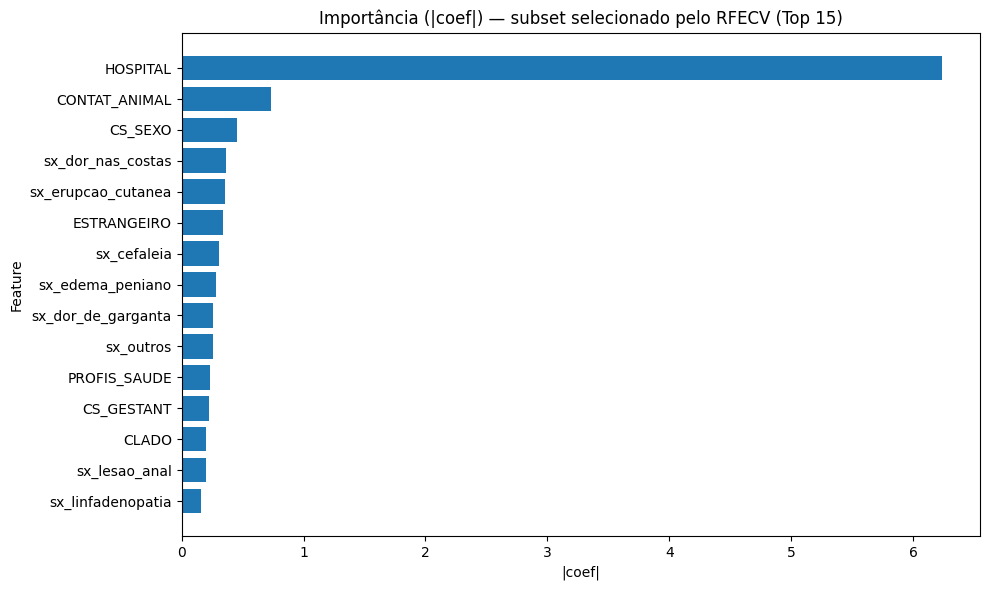

In [32]:
# B. Ranking das features selecionadas pelo RFECV usando |coef| (Regressão Logística)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Coeficientes do modelo ajustado no RFECV (já treinado)
coef = np.abs(rfecv.estimator_.coef_).ravel()
rank_df = pd.DataFrame({
    "feature": selected_rfecv,
    "|coef|": coef
}).sort_values("|coef|", ascending=False)

print("🏆 Top 15 (por |coef|) dentro do subset selecionado:")
print(rank_df.head(15))

# Barplot
top_n = 15
plt.figure(figsize=(10,6))
plt.barh(rank_df["feature"].head(top_n)[::-1], rank_df["|coef|"].head(top_n)[::-1])
plt.title(f"Importância (|coef|) — subset selecionado pelo RFECV (Top {top_n})")
plt.xlabel("|coef|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [33]:
# C. Auditoria de ranking do RFE “simples” (se quiseres comparar com um RFE fixo)

from sklearn.feature_selection import RFE

rfe_fixed = RFE(estimator=LogisticRegression(max_iter=1000, solver="liblinear"),
                n_features_to_select=20, step=1)
rfe_fixed.fit(X_base, y_base)

audit_df = pd.DataFrame({
    "feature": X_base.columns,
    "selected_RFE": rfe_fixed.support_,
    "rank_RFE": rfe_fixed.ranking_
}).sort_values(["selected_RFE","rank_RFE"], ascending=[False, True])

print("📋 Auditoria RFE (selected, rank):")
print(audit_df.head(25))


📋 Auditoria RFE (selected, rank):
                 feature  selected_RFE  rank_RFE
3                CS_SEXO          True         1
11            CS_GESTANT          True         1
12           ESTRANGEIRO          True         1
16          PROFIS_SAUDE          True         1
19  TRATAMENTO_MONKEYPOX          True         1
20              HOSPITAL          True         1
22           VINCULO_EPI          True         1
26         CONTAT_ANIMAL          True         1
29                 CLADO          True         1
33    sx_erupcao_cutanea          True         1
36           sx_cefaleia          True         1
37       sx_adenomegalia          True         1
38       sx_dor_muscular          True         1
40         sx_lesao_anal          True         1
41     sx_dor_nas_costas          True         1
42    sx_dor_de_garganta          True         1
44     sx_linfadenopatia          True         1
45             sx_outros          True         1
49      sx_edema_peniano          T

---
### 📊 Visualização — Importâncias das Variáveis
---

O gráfico abaixo mostra as variáveis mais relevantes segundo o critério de **redução de impureza** do Random Forest.  
Esse tipo de ranking facilita a interpretação e fornece uma visão complementar ao RFE.  

📖 *“Feature importance scores in decision tree ensembles provide an interpretable measure of how strongly each attribute contributes to prediction.”*  
— **Kelleher et al., Cap. 5.4, p. 229 (2nd Ed.)**


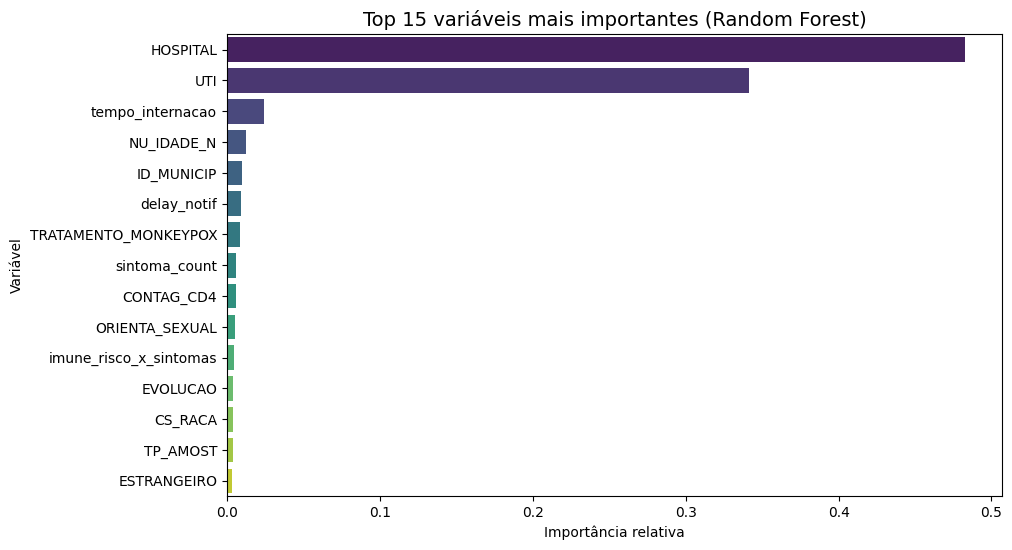

In [34]:
# 3. Visualização — Importâncias das variáveis (Random Forest)

#import seaborn as sns
#import matplotlib.pyplot as plt

# Selecionar top 15 variáveis mais importantes
top_n = 15
top_features = importances.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis", hue=top_features.index, legend=False)
plt.title(f"Top {top_n} variáveis mais importantes (Random Forest)", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Variável")
plt.show()


### 3️⃣ Redução de Dimensionalidade (opcional)
- 📐 **PCA (Principal Component Analysis)**  
  - Reduz dimensionalidade criando **componentes principais** (combinações lineares das variáveis).  
  - Preserva variância máxima dos dados, mas perde interpretabilidade direta.  
  - Útil quando ainda há muitas variáveis ou colinearidade residual.  

- 🔬 **Outras técnicas possíveis:**  
  - **LDA (Linear Discriminant Analysis):** supervisionado, otimiza separação entre classes.  
  - **ICA (Independent Component Analysis):** busca independência estatística, útil para dados de sinais.  

  >📖 *Cap. 3.5 Advanced Data Exploration, p. 85* (correlação e redundância)  
  >📖 *Cap. 10 Dimensionality Reduction, p. 455–460* (PCA e variantes)  

---

### 4️⃣ Dataset Final
- Após filtros estatísticos, métodos supervisionados e/ou redução de dimensionalidade →  
- Obtemos um dataset **otimizado**:  
  - Informativo  
  - Não redundante  
  - Parcimonioso (menos atributos, melhor generalização)  

👉 Esse dataset final é a entrada para a **Modelagem Preditiva Binária** (hospitalização, óbito etc.).  



#SEÇÃO FEITA MAS PRECISA DE REANÁLISE APÓS IMPLEMENTAR BENCHMARKING DOS ALVOS


---
## 📌 Nota da Seção – Dataset após Engenharia e Seleção de Atributos
---

### 🔄 Fluxo de Dataframes
- `df_feateng` → saída da **Engenharia de Atributos**, derivado de `df_prep`.  
- `df_atribsel_final` → derivado de `df_feateng`, após aplicação dos filtros de seleção:  
  - Remoção de inviáveis (datas, IDs técnicos, texto cru).  
  - Filtro estatístico de variância (< 1%).  
  - Filtro semântico/manual de redundâncias.  

### 📊 Impacto Quantitativo
- O dataset passou de **222** para **70** variáveis.  
- Foi realizado **diagnóstico de correlação** para identificar pares com correlação > 0.9.  

### 📖 Justificativa Metodológica
A eliminação de variáveis inviáveis, quase constantes e redundantes:  
- Reduz a dimensionalidade.  
- Melhora a generalização.  
- Mitiga o risco de *overfitting*.  

Esse processo segue as recomendações de *Kelleher et al.*:  
- **Cap. 3.5 Advanced Data Exploration, p. 85** → redundâncias e correlação.  
- **Cap. 5.4 Extensions and Variations, p. 227** → variância baixa e atributos não informativos.  


In [35]:
#Total de variáveis antes da seleção de atributos
df_feateng.shape[1]

222

In [36]:
#Total de variáveis após seleção de atributos
df_atribsel_final.shape[1]

70

#PENDÊNCIAS


---

## **Divisão de preditoras (X) e alvo (y)**

---

In [37]:
# 5.0 Divisão de preditoras (X) e alvo (y)
# ----------------------------------------
# - Objetivo: separar features (X) e variável-alvo (y).
# - Aqui você escolhe QUAL alvo quer balancear (hospitalização ou óbito).
# - Pré-requisito: df_encoded (ou df_enc) já codificado (OneHot) e sem colunas não-numéricas.
# - Observação: por ora, vamos seguir com 'target_hosp'; depois você pode trocar pelo alvo de óbito.

import pandas as pd

# Escolhe o alvo aqui:
target_col = "target_hosp"   # alternativas: "target_obito_any", "target_obito_mpx" (se estiverem com menor desbalanceamento)

# Verificações básicas
assert target_col in df_encoded.columns, f"Alvo '{target_col}' não existe em df_encoded."
assert set(df_encoded[target_col].dropna().unique()) <= {0,1}, "Alvo precisa ser binário (0/1)."

# Separa X e y
X = df_encoded.drop(columns=[target_col]).copy()
y = df_encoded[target_col].copy()

print("[5.0] X e y criados:", X.shape, y.shape)
print("Distribuição (%) do alvo selecionado:",
      (y.value_counts(normalize=True)*100).round(2).to_dict(), '\n')


NameError: name 'df_encoded' is not defined

---
## **Atividade 5: Balanceamento dos dados (Tomek e Smote)**
- Checar se os dados estão desbalanceados
- Aplicar os algoritmos Tomek e Smote
- Avaliar impacto no desempenho dos modelos treinados
---

### Checagem de desbalanceamento das classes


In [ ]:
# 5.1 Checagem de desbalanceamento das classes
# --------------------------------------------
# - Objetivo: medir a proporção das classes antes de balancear.
# - Saída: distribuição percentual e alerta visual simples.

from collections import Counter

dist_original = (y.value_counts(normalize=True) * 100).round(2).to_dict()
print(f"\nVariável-alvo: {target_col}")
print("\n[5.1] Distribuição (%) do alvo (Original -> Pós-codificação/escalonamento):\n", dist_original)

# Regras práticas (heurística):
#   - Se min(classe) < 20% → dataset bastante desbalanceado
#   - Entre 20% e 40% → moderadamente desbalanceado
minority_pct = min(dist_original.values())
if minority_pct < 20:
    print("\n⚠️ Alerta: classe minoritária < 20% (desbalanceamento alto).")
elif minority_pct < 40:
    print("ℹ️ Observação: desbalanceamento moderado.")
else:
    print("✅ Classes relativamente equilibradas.")


### 🔧 Sanitização e Imputação só para Balanceamento (garante só numéricos)

In [ ]:
# 5.2 Sanitização/Imputação (só para balanceamento) + Escalonamento
# ------------------------------------------------------------------
# - Objetivo: garantir que X esteja 100% numérico e sem NaN antes do Tomek/SMOTE.
# - Passos:
#   1) Selecionar apenas colunas numéricas (df_encoded já tende a ser numérico após OneHot).
#   2) Imputar com mediana (robusta a outliers) — SOMENTE para esta etapa técnica.
#   3) Padronizar (StandardScaler) para que SMOTE/Tomek usem distâncias sem viés de escala.
# - Observação: Na modelagem final (cv/grid search), faremos TUDO em pipeline para evitar vazamento.

#import numpy as np
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler

# 1) Garante numéricos
X_num = X.select_dtypes(include=[np.number]).copy()
drop_cols = [c for c in X.columns if c not in X_num.columns]
if drop_cols:
    print(f"[5.2] Removidas do X (não numéricas para balanceamento): {drop_cols}")

# 2) Imputação simples (mediana)
imp_bal = SimpleImputer(strategy="median")
X_num_imp = pd.DataFrame(
    imp_bal.fit_transform(X_num),
    columns=X_num.columns,
    index=X_num.index
)

# 3) Escalonamento (StandardScaler)
scaler_bal = StandardScaler()
X_num_imp_scaled = pd.DataFrame(
    scaler_bal.fit_transform(X_num_imp),
    columns=X_num.columns,
    index=X_num.index
)

print("[5.2] X_num_imp_scaled pronto para Tomek/SMOTE:", X_num_imp_scaled.shape)

# (Opcional) Salvar artefatos técnicos desta etapa
# X_num_imp_scaled.to_csv("X_balance_ready.csv", index=False)
# y.to_csv("y_balance_ready.csv", index=False)


### **Tomek Links (remoção de pares fronteira)**

In [ ]:
# 5.3 Tomek Links
# ----------------
# - Objetivo: remover pares (maioria/minoria) que formam "bordas" ruidosas, deixando as classes mais separáveis.
# - Deve rodar APÓS escalonamento (distâncias ficam corretas).
# - Resultado: base levemente menor e menos ruído.

#from imblearn.under_sampling import TomekLinks

tl = TomekLinks(n_jobs=-1)
X_tomek, y_tomek = tl.fit_resample(X_num_imp_scaled, y)

dist_tomek = (y_tomek.value_counts(normalize=True) * 100).round(2).to_dict()
print("[5.3] Pós-Tomek — distribuição (%):", dist_tomek)
print("[5.3] Shape:", X_tomek.shape)


### **SMOTE (_Oversampling_ da Minoritária)**


In [ ]:
# 5.4 Balanceamento com SMOTE (Synthetic Minority Oversampling Technique)
# ----------------------------------------------------------------------
# Objetivo: gerar amostras sintéticas da classe minoritária para reduzir desbalanceamento.
# Sequência recomendada: aplicar após Tomek Links (limpa ruídos/pares conflitantes),
#                        mas SMOTE também pode ser usado isoladamente.
# Param k_neighbors: nº de vizinhos usados para gerar pontos sintéticos.
#   - Ajuste dinâmico: k = min(5, minority_count - 1) → evita erro quando minoria tem poucos registros.
# Param random_state: garante reprodutibilidade.
# Obs: SMOTE não aceita 'n_jobs' (não paraleliza internamente).

#from imblearn.over_sampling import SMOTE

minority_count = y_tomek.value_counts().min()
k = min(5, max(1, minority_count - 1))

smote = SMOTE(k_neighbors=k, random_state=42)
X_tomek_smote, y_tomek_smote = smote.fit_resample(X_tomek, y_tomek)

dist_tomek_smote = (y_tomek_smote.value_counts(normalize=True) * 100).round(2).to_dict()
print("[5.4] Pós-Tomek/SMOTE — distribuição (%):", dist_tomek_smote)
print("[5.4] Shape:", X_tomek_smote.shape)


## 💾 Salvamento de Bases Balanceadas


In [ ]:
# (Opcional) salvar bases balanceadas
pd.DataFrame(X_tomek, columns=X_num_imp_scaled.columns).to_csv("X_mpox_2022_target_hosp_tomek.csv", index=False)
y_tomek.to_csv("y_mpox_2022_target_hosp_tomek.csv", index=False)
pd.DataFrame(X_tomek_smote, columns=X_num_imp_scaled.columns).to_csv("X_mpox_2022_target_hosp_tomek_smote.csv", index=False)
y_tomek_smote.to_csv("y_mpox_2022_target_hosp_tomek_smote.csv", index=False)

## Auditoria comparativa de balanceamento (Antes → Pós-Tomek → Pós-Tomek-SMOTE)

In [ ]:
# 5.5 Auditoria comparativa de balanceamento (Antes → Pós-Tomek → Pós-Tomek-SMOTE)
# ------------------------------------------------
# - Objetivo: comparar a distribuição das classes ao longo das etapas de balanceamento.
# ------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dist_original = (y.value_counts(normalize=True) * 100).round(2).to_dict()
dist_tomek    = (y_tomek.value_counts(normalize=True) * 100).round(2).to_dict()
dist_tomek_smote    = (y_tomek_smote.value_counts(normalize=True) * 100).round(2).to_dict()

audit_balance = pd.DataFrame({
    "Antes (%)": dist_original,
    "Após Tomek (%)": dist_tomek,
    "Após Tomek/SMOTE (%)": dist_tomek_smote
}).T

print("=== Auditoria comparativa do balanceamento ===")
print(audit_balance)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.barplot(x=list(dist_original.keys()), y=list(dist_original.values()),
            ax=axes[0], color="lightblue", edgecolor="gray")
axes[0].set_title("Antes")

sns.barplot(x=list(dist_tomek.keys()), y=list(dist_tomek.values()),
            ax=axes[1], color="lightgreen", edgecolor="gray")
axes[1].set_title("Após Tomek")

sns.barplot(x=list(dist_tomek_smote.keys()), y=list(dist_tomek_smote.values()),
            ax=axes[2], color="green", edgecolor="gray")
axes[2].set_title("Após Tomek/SMOTE")

for ax in axes:
    ax.set_xlabel("Classe")
    ax.set_ylabel("Percentual (%)")

plt.suptitle(f"Comparação de distribuição — alvo: {target_col}", fontsize=13)
plt.tight_layout()
plt.show()


## 💾 Serialização dos dados balanceados (Pós Tomek-SMOTE)

In [ ]:
# 💾 Serialização em Pickle (PKL) — Pós-SMOTE
# -------------------------------------------------
# Objetivo:
#   - Salvar os datasets balanceados em formato .pkl
#   - Preserva dtypes (ex: Int64, categorias) que podem se perder no CSV
# Saída:
#   - X_mpox_2022_target_hosp_tomek_smote.pkl
#   - y_mpox_2022_target_hosp_tomek_smote.pkl
# -------------------------------------------------

#import joblib

# Caminhos de saída
X_tomek_smote_pkl = "X_mpox_2022_target_hosp_tomek_smote.pkl"
y_tomek_smote_pkl = "y_mpox_2022_target_hosp_tomek_smote.pkl"

# Serializa com joblib (mais eficiente para DataFrames grandes)
joblib.dump(pd.DataFrame(X_tomek_smote, columns=X_num_imp_scaled.columns), X_tomek_smote_pkl)
joblib.dump(y_tomek_smote, y_tomek_smote_pkl)

print(f"✔️ X_tomek_smote salvo em: {X_tomek_smote_pkl}")
print(f"✔️ y_tomek_smote salvo em: {y_tomek_smote_pkl}")

# Checagem pós-salvamento
X_check = joblib.load(X_tomek_smote_pkl)
y_check = joblib.load(y_tomek_smote_pkl)

print("\nChecagem pós-salvamento PKL:")
print("X_tomek_smote:", X_check.shape, "→ dtypes:", X_check.dtypes.unique())
print("y_tomek_smote:", y_check.shape, "→ dtype:", y_check.dtypes)
print(f"\nDistribuição alvo ({y_tomek_smote_pkl[0:-4]}):")
print("🎯Variável-alvo:", )
print(y_check.value_counts(normalize=True) * 100)


## 📂 Desserialização do dataset pré-processado

In [ ]:
# 📂 Desserialização do dataset pré-processado

filename = project_path + f"mpox_2022_prep.parquet"
df_prep = pd.read_parquet(filename)
print("✅ df_prep carregado com sucesso:", df_prep.shape)

# Visualizar primeiras linhas
df_prep.head(1)

---
## **🤖 Modelagem — treino e avaliação dos algoritmos supervisionados**
### **Atividade 6: Treinamento dos modelos de Machine Learning**
- Comparar modelos: testar diferentes classificadores
    - Classificação binária
    - Modelos: Naive Bayes, Árvore de Decisão, Random Forest, Aprendizagem baseada em instâncias - kNN, Regressão logística, SVM, Redes Neurais Artificiais
- Medir desempenho com métricas adequadas e evitar overfitting
- Investigar como técnicas de imputação e codificação impactam os resultados
- Escolher e ajustar modelos (gridsearch/validação cruzada)
---

Configuração Inicial:

- 📦 Importação das bibliotecas
- 🔄 Carregar dados já pré-processados (Tomek + SMOTE aplicados)
- ✂️ Divisão treino/teste


In [ ]:
# ================================
# 📦 Importação das bibliotecas
# ================================
# pandas/numpy → manipulação de dados
import pandas as pd
import numpy as np

# sklearn → modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

# visualização
import matplotlib.pyplot as plt
import seaborn as sns

# salvar/carregar modelos
import joblib

# ================================
# 🔄 Carregar dados já pré-processados (Tomek + SMOTE aplicados)
# ================================
X = joblib.load("/content/X_mpox_2022_target_hosp_tomek_smote.pkl")
y = joblib.load("/content/y_mpox_2022_target_hosp_tomek_smote.pkl")

# ================================
# ✂️ Divisão treino/teste
# - Mantemos proporção de classes (stratify=y)
# - 80% treino, 20% teste
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamanho treino:", X_train.shape, " | Tamanho teste:", X_test.shape)
print("Distribuição classes (treino):\n", y_train.value_counts(normalize=True))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Função auxiliar de avaliação

In [ ]:
def avaliar_modelo(modelo, X_train, y_train, X_test, y_test, nome_modelo):
    """
    Treina e avalia um modelo de classificação.

    Passos:
    1. Treina com dados de treino.
    2. Prediz nos dados de teste.
    3. Calcula métricas (Accuracy, Precision, Recall, F1, AUC).
    4. Exibe relatório, matriz de confusão e curva ROC.

    Retorna: dicionário com métricas principais (para comparação entre modelos).
    """
    # Treinamento do modelo
    modelo.fit(X_train, y_train)

    # Predição
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None

    # Cálculo das métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    # Exibição de resultados
    print(f"\n📊 Resultados - {nome_modelo}")
    print(classification_report(y_test, y_pred))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred))
    print(f"AUC: {auc:.3f}")

    # Curva ROC (quando disponível)
    if y_proba is not None:
        RocCurveDisplay.from_estimator(modelo, X_test, y_test)
        plt.title(f"Curva ROC - {nome_modelo}")
        plt.show()

    # Retorno para comparação final
    return {"Modelo": nome_modelo, "Accuracy": acc, "Precision": prec,
            "Recall": rec, "F1": f1, "AUC": auc}

# Lista para armazenar os resultados de todos os modelos
resultados = []


In [ ]:
# Visualização rápida
print(X.head(1))
print(y.value_counts())

#type(X_loaded)
#type(y_loaded)


🔹 1. Naive Bayes

📘 Teoria: assume independência condicional entre atributos (Kelleher, cap. 8).
Bom para baseline rápido, mesmo que a suposição seja simplista.

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
resultados.append(avaliar_modelo(nb, X_train, y_train, X_test, y_test, "Naive Bayes"))


🔹 2. Regressão Logística

📘 Teoria: modelo linear que estima probabilidades. Muito usado em saúde pela interpretabilidade (odds ratio).

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
resultados.append(avaliar_modelo(log_reg, X_train, y_train, X_test, y_test, "Regressão Logística"))


🔹 3. Árvore de Decisão

📘 Teoria: gera regras hierárquicas “if-then”. Boa interpretabilidade, mas risco de overfitting se não podada.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
resultados.append(avaliar_modelo(tree, X_train, y_train, X_test, y_test, "Árvore de Decisão"))


🔹 4. kNN

📘 Teoria: classifica pelo “voto” dos vizinhos mais próximos. Simples, mas sensível a escala e dados ruidosos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)  # k=5 é default, pode ser ajustado
resultados.append(avaliar_modelo(knn, X_train, y_train, X_test, y_test, "kNN"))


🔹 5. Random Forest

📘 Teoria: conjunto de várias árvores de decisão com amostragem aleatória. Reduz overfitting, aumenta robustez

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
resultados.append(avaliar_modelo(rf, X_train, y_train, X_test, y_test, "Random Forest"))


🔹 6. SVM

📘 Teoria: encontra hiperplano ótimo para separar classes. Potente em dados complexos, mas exige tuning (kernel, C, γ).

In [ ]:
from sklearn.svm import SVC

svm = SVC(probability=True, random_state=42)  # probability=True para permitir ROC
resultados.append(avaliar_modelo(svm, X_train, y_train, X_test, y_test, "SVM"))


🔹 7. Rede Neural (MLP)

📘 Teoria: modelo inspirado no cérebro humano, com múltiplas camadas ocultas. Captura padrões complexos, mas menos interpretável.

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
resultados.append(avaliar_modelo(mlp, X_train, y_train, X_test, y_test, "Rede Neural (MLP)"))


🔹 Comparação final entre modelos

In [ ]:
# Criar DataFrame comparativo
df_resultados = pd.DataFrame(resultados)

print("\n📊 Comparação de Métricas entre Modelos")
display(df_resultados.sort_values(by="F1", ascending=False))


---
## **Atividade 7: Usar o modelo treinado**
- Salvar os transformadores
- Salvar o modelo
- Fazer predição usando dados novos
---


Naive Bayes

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = nb

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


SVM

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = nb

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Árvore de Decisão

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = tree

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_nb.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_nb.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Rede Neural (MLP)

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = mlp

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_mlp.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_mlp.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Random Forest

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = rf

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_rf.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_rf.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


Regressão Logística

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = log_reg

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_log_reg.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_log_reg.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


kNN

In [ ]:
# ✅ Exemplo: supondo que Random Forest foi o melhor (ajustar conforme resultados)
modelo_final = knn

# Salvar pipeline completo (inclui pré-processamentos e modelo final)
joblib.dump(modelo_final, "modelo_final_knn.pkl")

# Recarregar modelo para validar reutilização
modelo_carregado = joblib.load("modelo_final_knn.pkl")

# Simular predição em 5 registros de teste
amostra = X_test.iloc[:5]
print("\n🔮 Predições em novos dados simulados:")
print("Probabilidades:", modelo_carregado.predict_proba(amostra))
print("Classe prevista:", modelo_carregado.predict(amostra))


In [ ]:
import os

# ================================
# 📂 Criar pasta para salvar os modelos
# ================================
os.makedirs("modelos_salvos", exist_ok=True)

# ================================
# 🔄 Loop para salvar e recarregar todos os modelos
# ================================
modelos_treinados = {
    "NaiveBayes": nb,
    "RegressaoLogistica": log_reg,
    "ArvoreDecisao": tree,
    "kNN": knn,
    "RandomForest": rf,
    "SVM": svm,
    "RedeNeuralMLP": mlp
}

for nome, modelo in modelos_treinados.items():
    print(f"\n=== 🔄 Testando reuso do modelo: {nome} ===")

    # 1. Salvar modelo em arquivo PKL
    caminho = f"modelos_salvos/{nome}.pkl"
    joblib.dump(modelo, caminho)
    print(f"✅ Modelo salvo em: {caminho}")

    # 2. Recarregar modelo salvo
    modelo_carregado = joblib.load(caminho)

    # 3. Testar predição em uma pequena amostra (5 registros de teste)
    amostra = X_test.iloc[:5]
    pred = modelo_carregado.predict(amostra)
    proba = modelo_carregado.predict_proba(amostra)[:,1] if hasattr(modelo_carregado, "predict_proba") else "N/A"

    print("🔮 Predições:", pred)
    print("📊 Probabilidades:", proba)


In [ ]:
# 2. Seleção supervisionada — Feature Importance (Random Forest)

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

top_n = 15

# Modelo de árvore em ensemble
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# Ranking de importâncias
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("🏆 Top 15 variáveis mais importantes (Random Forest):")
print(importances.head(top_n))

In [ ]:
# B. Ranking das features selecionadas pelo RFECV usando |coef| (Regressão Logística)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Coeficientes do modelo ajustado no RFECV (já treinado)
coef = np.abs(rfecv.estimator_.coef_).ravel()
rank_df = pd.DataFrame({
    "feature": selected_rfecv,
    "|coef|": coef
}).sort_values("|coef|", ascending=False)

print("🏆 Top 15 (por |coef|) dentro do subset selecionado:")
print(rank_df.head(15))

# Barplot
top_n = 15
plt.figure(figsize=(10,6))
plt.barh(rank_df["feature"].head(top_n)[::-1], rank_df["|coef|"].head(top_n)[::-1])
plt.title(f"Importância (|coef|) — subset selecionado pelo RFECV (Top {top_n})")
plt.xlabel("|coef|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()